In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.ensemble.partial_dependence import partial_dependence

In [3]:
data = pd.read_csv("shot_logs.csv")
data.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128069 entries, 0 to 128068
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   GAME_ID                     128069 non-null  int64  
 1   MATCHUP                     128069 non-null  object 
 2   LOCATION                    128069 non-null  object 
 3   W                           128069 non-null  object 
 4   FINAL_MARGIN                128069 non-null  int64  
 5   SHOT_NUMBER                 128069 non-null  int64  
 6   PERIOD                      128069 non-null  int64  
 7   GAME_CLOCK                  128069 non-null  object 
 8   SHOT_CLOCK                  122502 non-null  float64
 9   DRIBBLES                    128069 non-null  int64  
 10  TOUCH_TIME                  128069 non-null  float64
 11  SHOT_DIST                   128069 non-null  float64
 12  PTS_TYPE                    128069 non-null  int64  
 13  SHOT_RESULT   

In [5]:
data.drop(["CLOSEST_DEFENDER_PLAYER_ID", "GAME_ID", "player_name", "player_id"], axis=1, inplace=True)

In [6]:
match_info = data["MATCHUP"].str.split(" - ", n=1, expand=True)
data["MONTH"] = pd.to_datetime(match_info[0]).dt.month
teams = match_info[1].str.split(" ", expand=True)
teams[0], teams[2] = np.where(teams[1] == "@", [teams[2], teams[0]], [teams[0], teams[2]])
data["HOME_TEAM"] = teams[0]
data["AWAY_TEAM"] = teams[2]
data["TEAM"] = np.where(data["LOCATION"] == "H", data["HOME_TEAM"], data["AWAY_TEAM"])
data["OPPOSING_TEAM"] = np.where(data["LOCATION"] == "H", data["AWAY_TEAM"], data["HOME_TEAM"])
data.drop(["MATCHUP", "HOME_TEAM", "AWAY_TEAM"], axis=1, inplace=True)

In [7]:
data.TEAM

0         CHA
1         CHA
2         CHA
3         CHA
4         CHA
         ... 
128064    BKN
128065    BKN
128066    BKN
128067    BKN
128068    BKN
Name: TEAM, Length: 128069, dtype: object

In [8]:
period_time = pd.to_datetime(data["GAME_CLOCK"], format="%M:%S")
data.drop("GAME_CLOCK", axis=1, inplace=True)
data["PERIOD_CLOCK"] = period_time.dt.minute*60 + period_time.dt.second

In [9]:
pd.get_dummies(data["SHOT_RESULT"])["made"].astype("bool").equals(data["FGM"].astype("bool"))


True

In [10]:
data.drop("SHOT_RESULT", axis=1, inplace=True)


In [11]:
data.drop("PTS", axis=1, inplace=True)
data.drop("W", axis=1, inplace=True)


In [12]:
data.describe(include="all")


,LOCATION,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER,CLOSE_DEF_DIST,FGM,MONTH,TEAM,OPPOSING_TEAM,PERIOD_CLOCK
count,128069,128069.000000,128069.000000,128069.000000,122502.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069,128069.000000,128069.000000,128069.000000,128069,128069,128069.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,473,NaN,NaN,NaN,30,30,NaN
top,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Ibaka, Serge",NaN,NaN,NaN,LAC,PHX,NaN
freq,64135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,814,NaN,NaN,NaN,4841,4543,NaN
mean,NaN,0.208723,6.506899,2.469427,12.453344,2.023355,2.765901,13.571504,2.264670,NaN,4.123015,0.452139,6.846434,NaN,NaN,351.393811
std,NaN,13.233267,4.713260,1.139919,5.763265,3.477760,3.043682,8.888964,0.441159,NaN,2.756446,0.497706,4.992854,NaN,NaN,207.590603
min,NaN,-53.000000,1.000000,1.000000,0.000000,0.000000,-163.600000,0.000000,2.000000,NaN,0.000000,0.000000,1.000000,NaN,NaN,0.000000
25%,NaN,-8.000000,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.000000,NaN,2.300000,0.000000,1.000000,NaN,NaN,172.000000
50%,NaN,1.000000,5.000000,2.000000,12.300000,1.000000,1.600000,13.700000,2.000000,NaN,3.700000,0.000000,11.000000,NaN,NaN,352.000000
75%,NaN,9.000000,9.000000,3.000000,16.675000,2.000000,3.700000,22.500000,3.000000,NaN,5.300000,1.000000,12.000000,NaN,NaN,531.000000


Text(0, 0.5, 'Total')

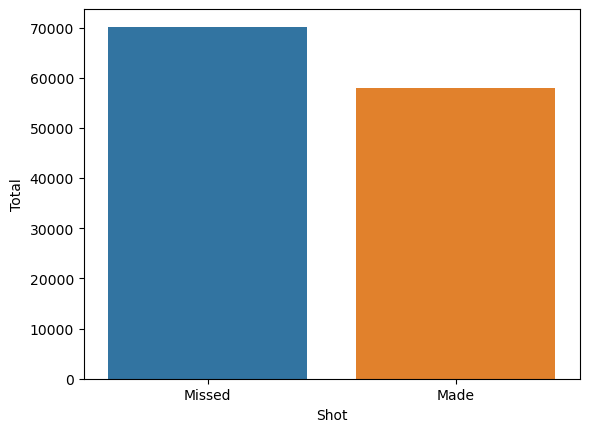

In [13]:
ax = sns.countplot(x="FGM", data=data)
ax.set_xticklabels(["Missed", "Made"])
ax.set_xlabel("Shot")
ax.set_ylabel("Total")

C:\Users\madha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


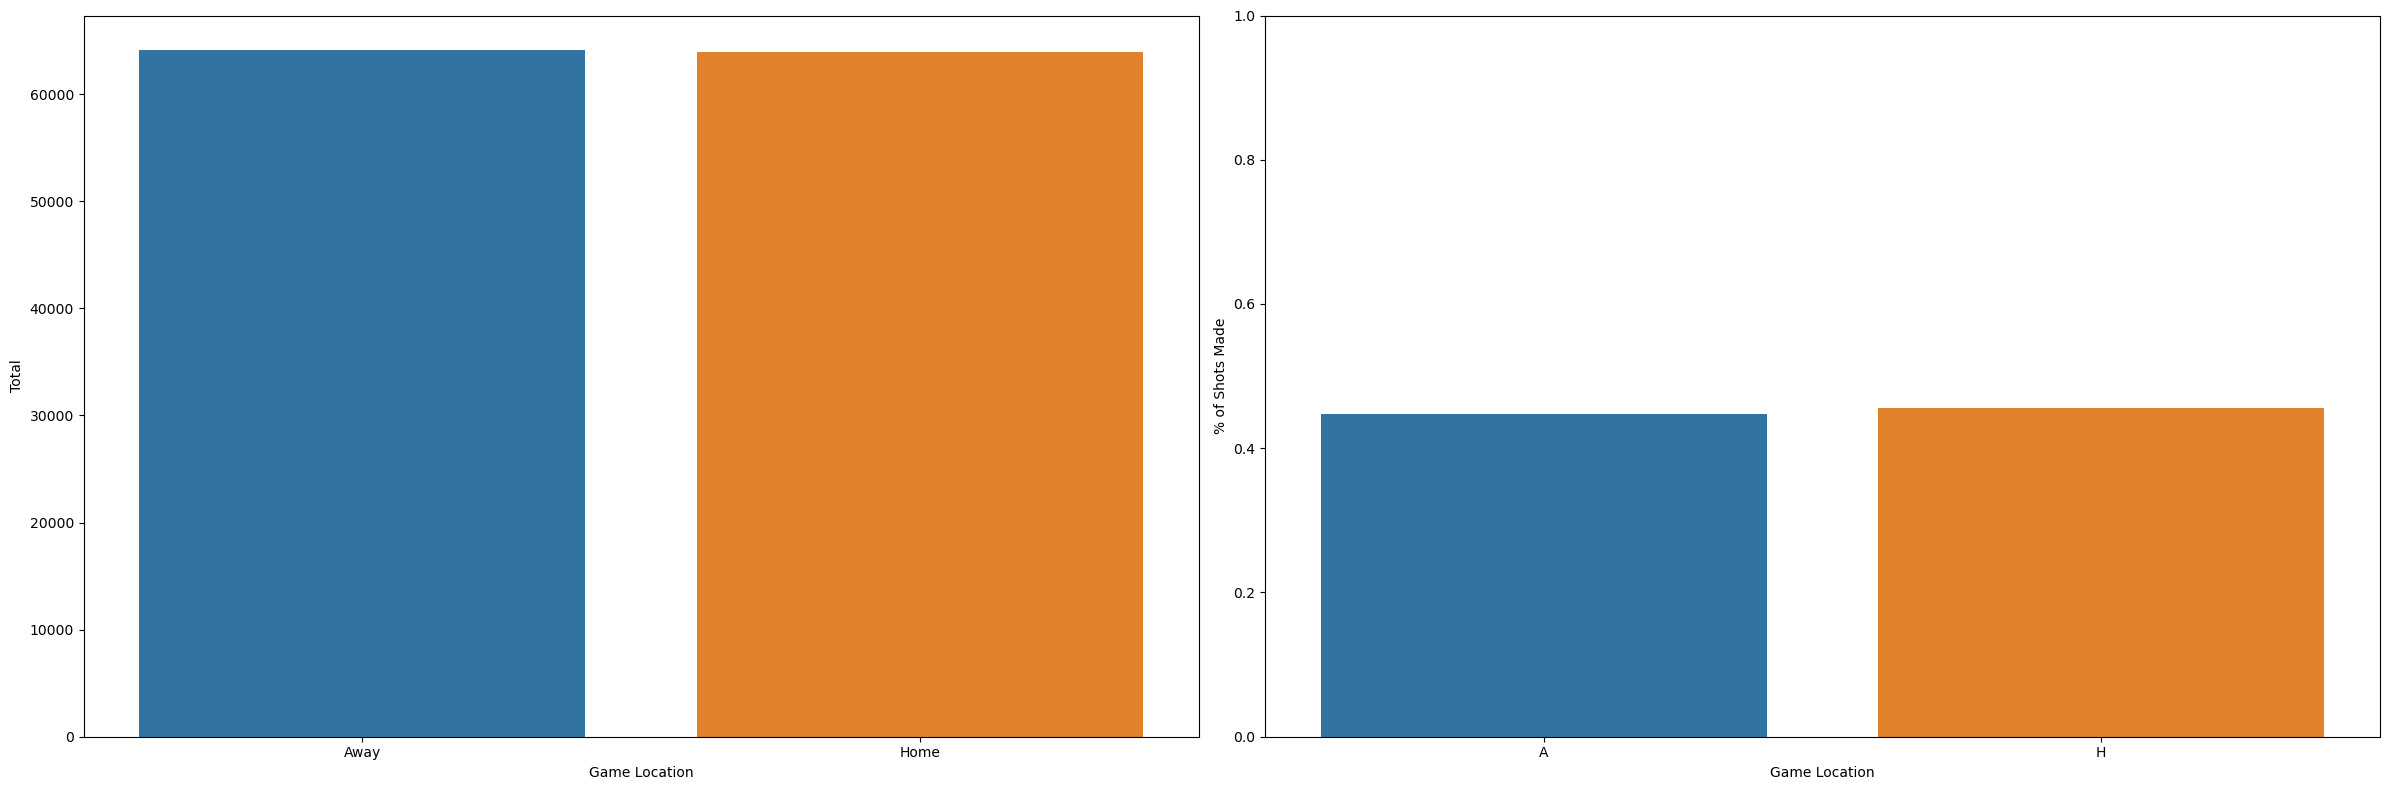

In [14]:
fig, axarr = plt.subplots(1, 2, figsize=(24,8))
sns.countplot(x="LOCATION", data=data, ax=axarr[0])
axarr[0].set_xticklabels(["Away", "Home"])
axarr[0].set_xlabel("Game Location")
axarr[0].set_ylabel("Total")
location = pd.crosstab(data["LOCATION"], data["FGM"]).reset_index()
location["Success_Rate"] = location[1] / (location[0] + location[1])
sns.barplot(location["LOCATION"], location["Success_Rate"], ax=axarr[1])
axarr[1].set_ylim((0, 1))
axarr[0].set_xticklabels(["Away", "Home"])
axarr[1].set_xlabel("Game Location")
axarr[1].set_ylabel("% of Shots Made")
fig.tight_layout()

C:\Users\madha\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\madha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


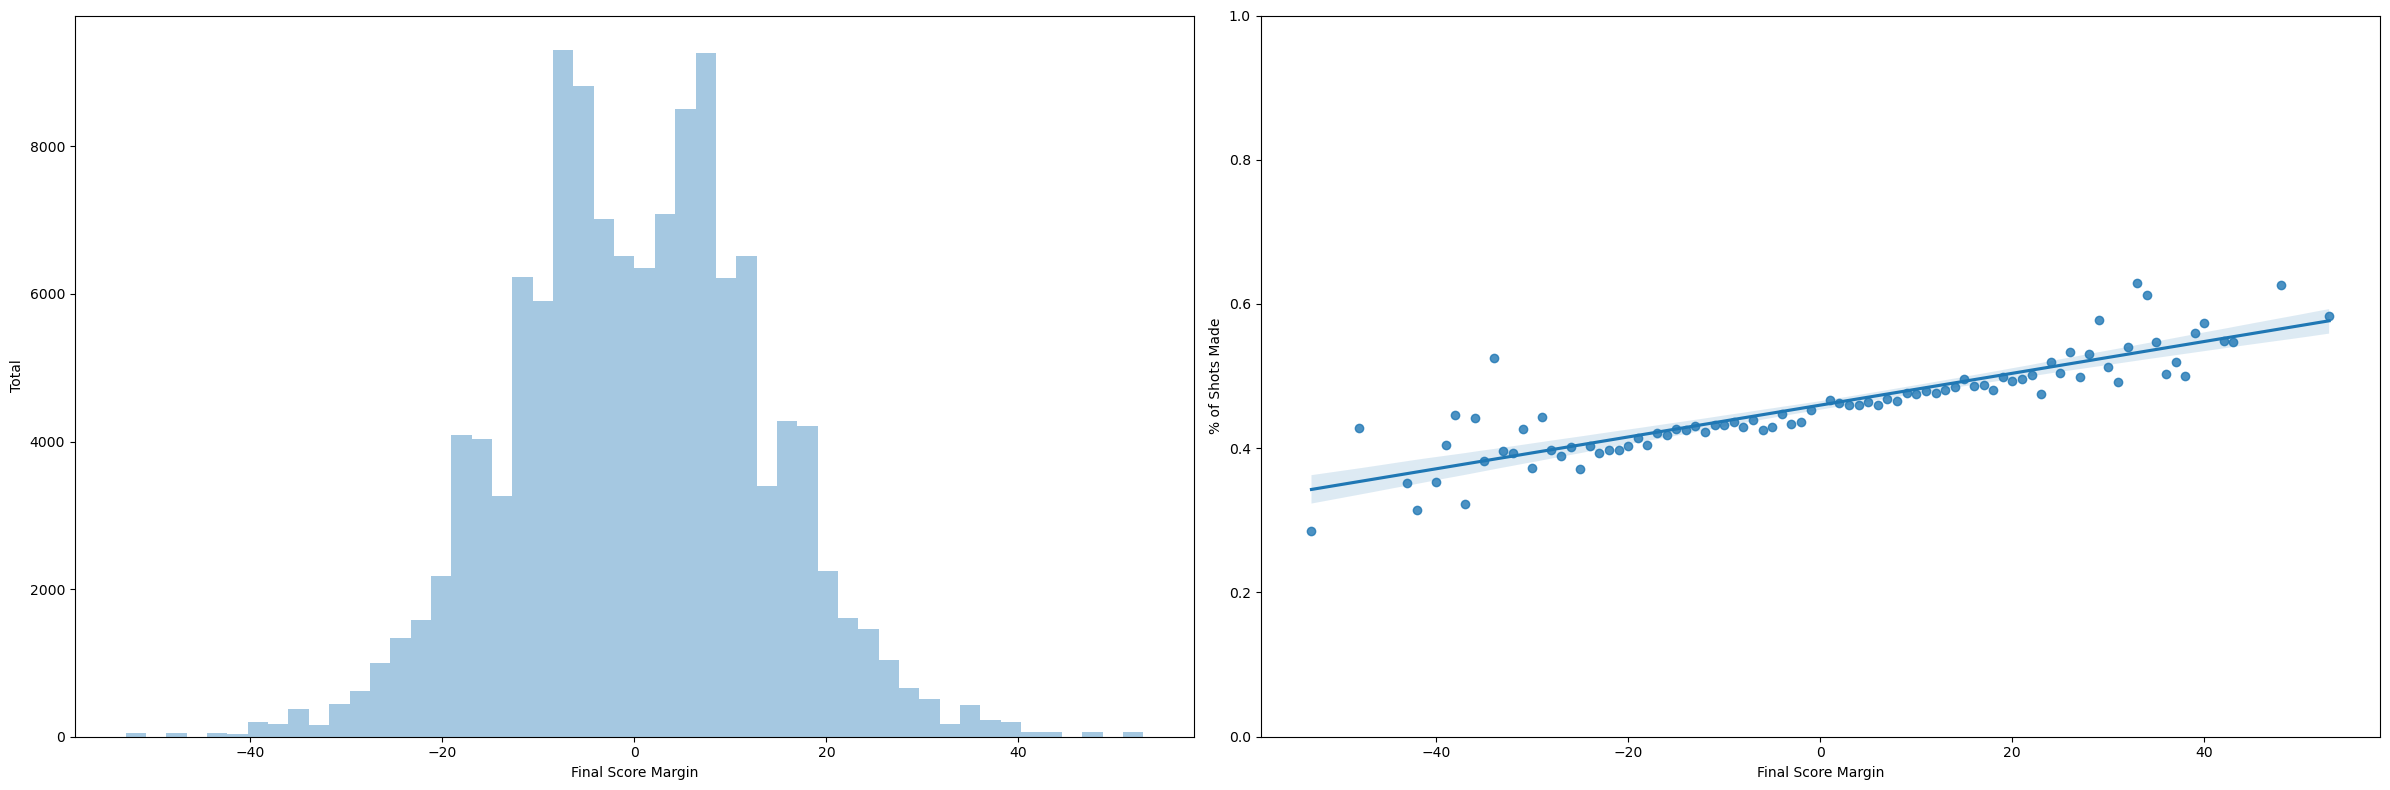

In [15]:
fig, axarr = plt.subplots(1, 2, figsize=(24,8))
sns.distplot(data["FINAL_MARGIN"], kde=False, ax=axarr[0])
axarr[0].set_xlabel("Final Score Margin")
axarr[0].set_ylabel("Total")
final_margin = pd.crosstab(data["FINAL_MARGIN"], data["FGM"]).reset_index()
final_margin["Success_Rate"] = final_margin[1] / (final_margin[0] + final_margin[1])
sns.regplot(final_margin["FINAL_MARGIN"], final_margin["Success_Rate"], ax=axarr[1])
axarr[1].set_ylim((0, 1))
axarr[1].set_xlabel("Final Score Margin")
axarr[1].set_ylabel("% of Shots Made")
fig.tight_layout()

C:\Users\madha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


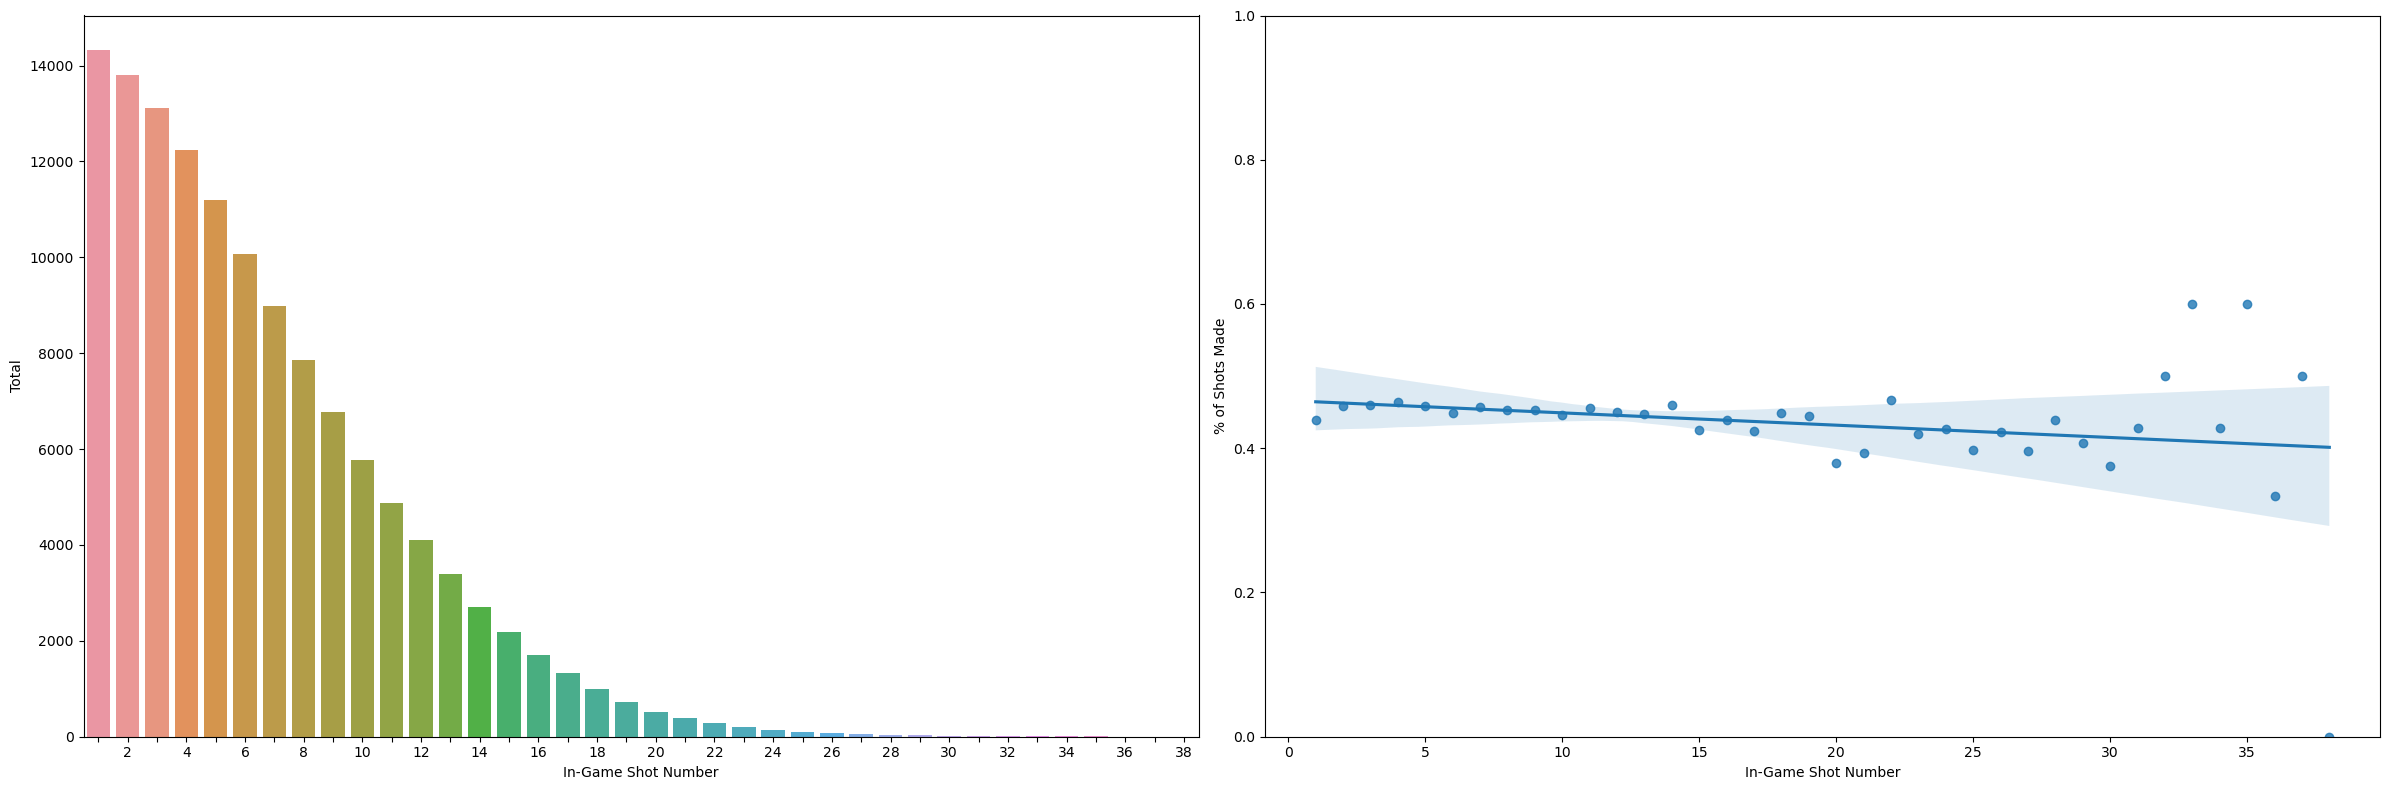

In [16]:
fig, axarr = plt.subplots(1, 2, figsize=(24, 8))
sns.countplot(x="SHOT_NUMBER", data=data, ax=axarr[0])
for label in axarr[0].xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
axarr[0].set_xlabel("In-Game Shot Number")
axarr[0].set_ylabel("Total")
shot_number = pd.crosstab(data["SHOT_NUMBER"], data["FGM"]).reset_index()
shot_number["Success_Rate"] = shot_number[1] / (shot_number[0] + shot_number[1])
sns.regplot(shot_number["SHOT_NUMBER"], shot_number["Success_Rate"], ax=axarr[1])
axarr[1].set_ylim((0, 1))
axarr[1].set_xlabel("In-Game Shot Number")
axarr[1].set_ylabel("% of Shots Made")
fig.tight_layout()

C:\Users\madha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


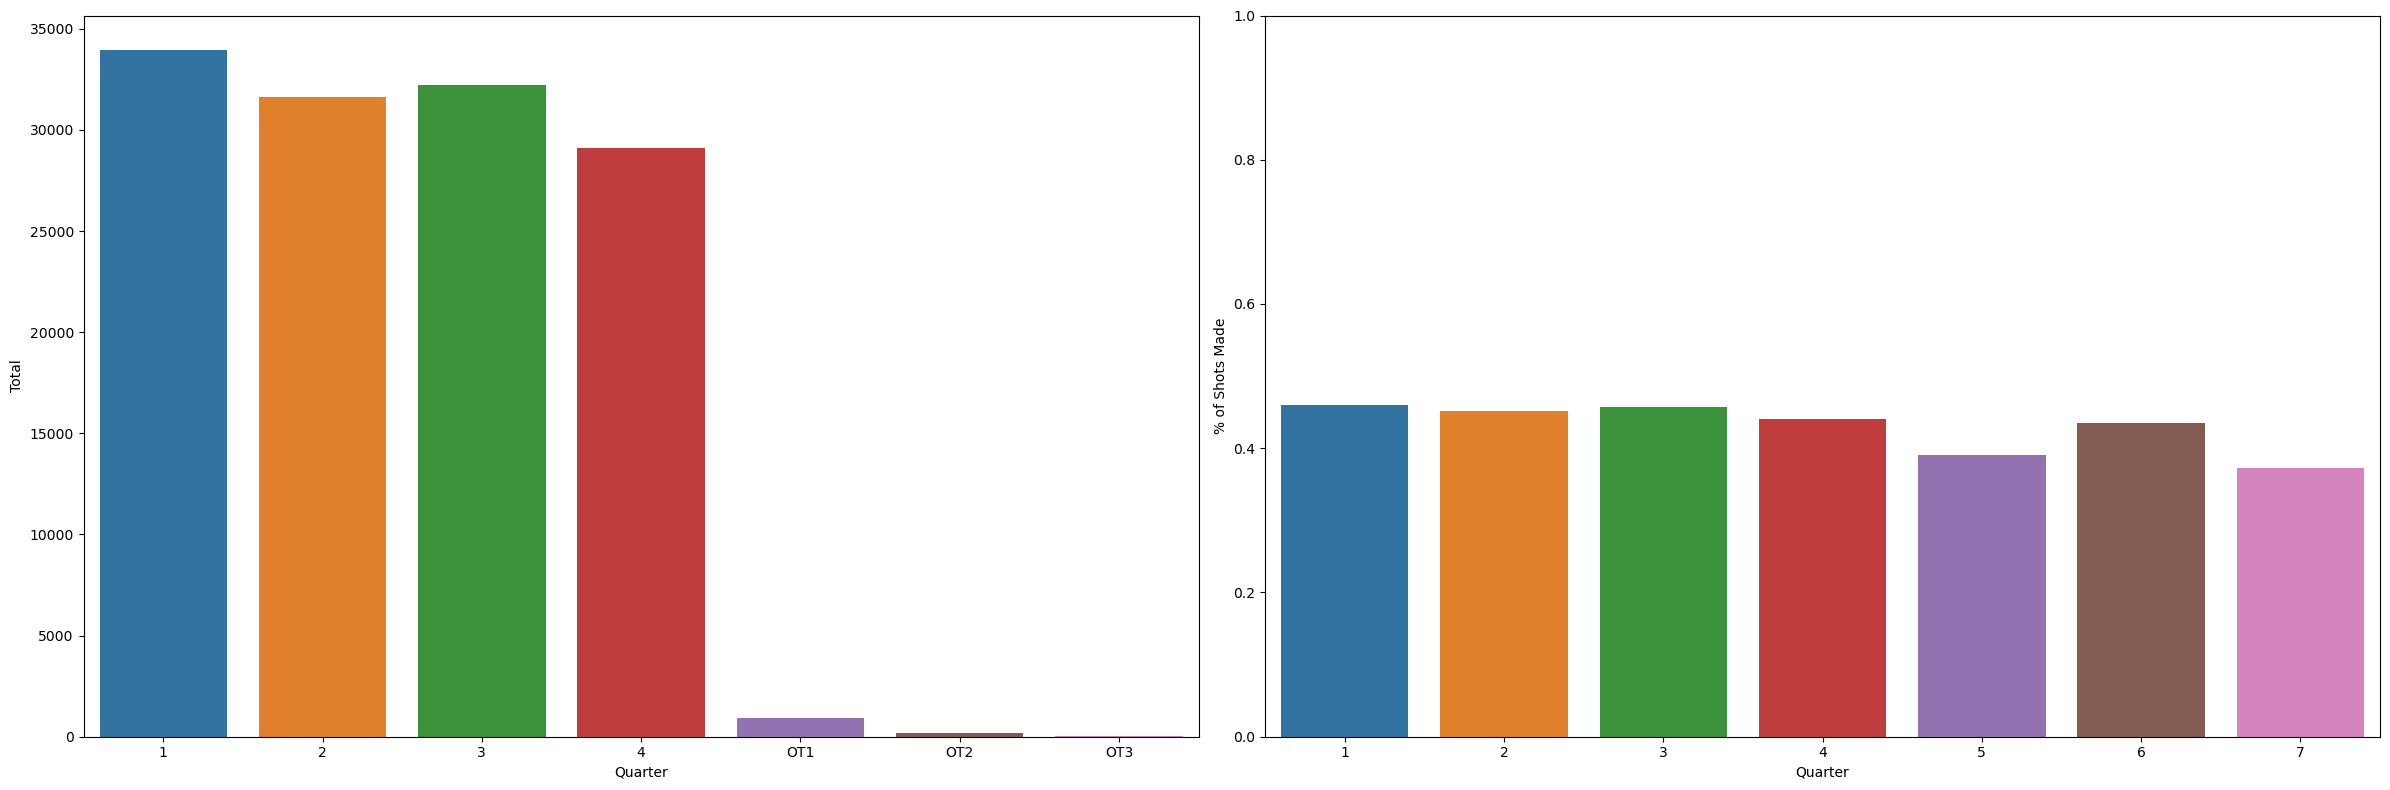

In [17]:
fig, axarr = plt.subplots(1, 2, figsize=(24, 8))
sns.countplot(x="PERIOD", data=data, ax=axarr[0])
axarr[0].set_xticklabels(["1", "2", "3", "4", "OT1", "OT2", "OT3"])
axarr[0].set_xlabel("Quarter")
axarr[0].set_ylabel("Total")
quarter = pd.crosstab(data["PERIOD"], data["FGM"]).reset_index()
quarter["Success_Rate"] = quarter[1] / (quarter[0] + quarter[1])
sns.barplot(quarter["PERIOD"], quarter["Success_Rate"], ax=axarr[1])
axarr[1].set_ylim((0, 1))
axarr[1].set_xlabel("Quarter")
axarr[1].set_ylabel("% of Shots Made")
fig.tight_layout()

C:\Users\madha\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\madha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


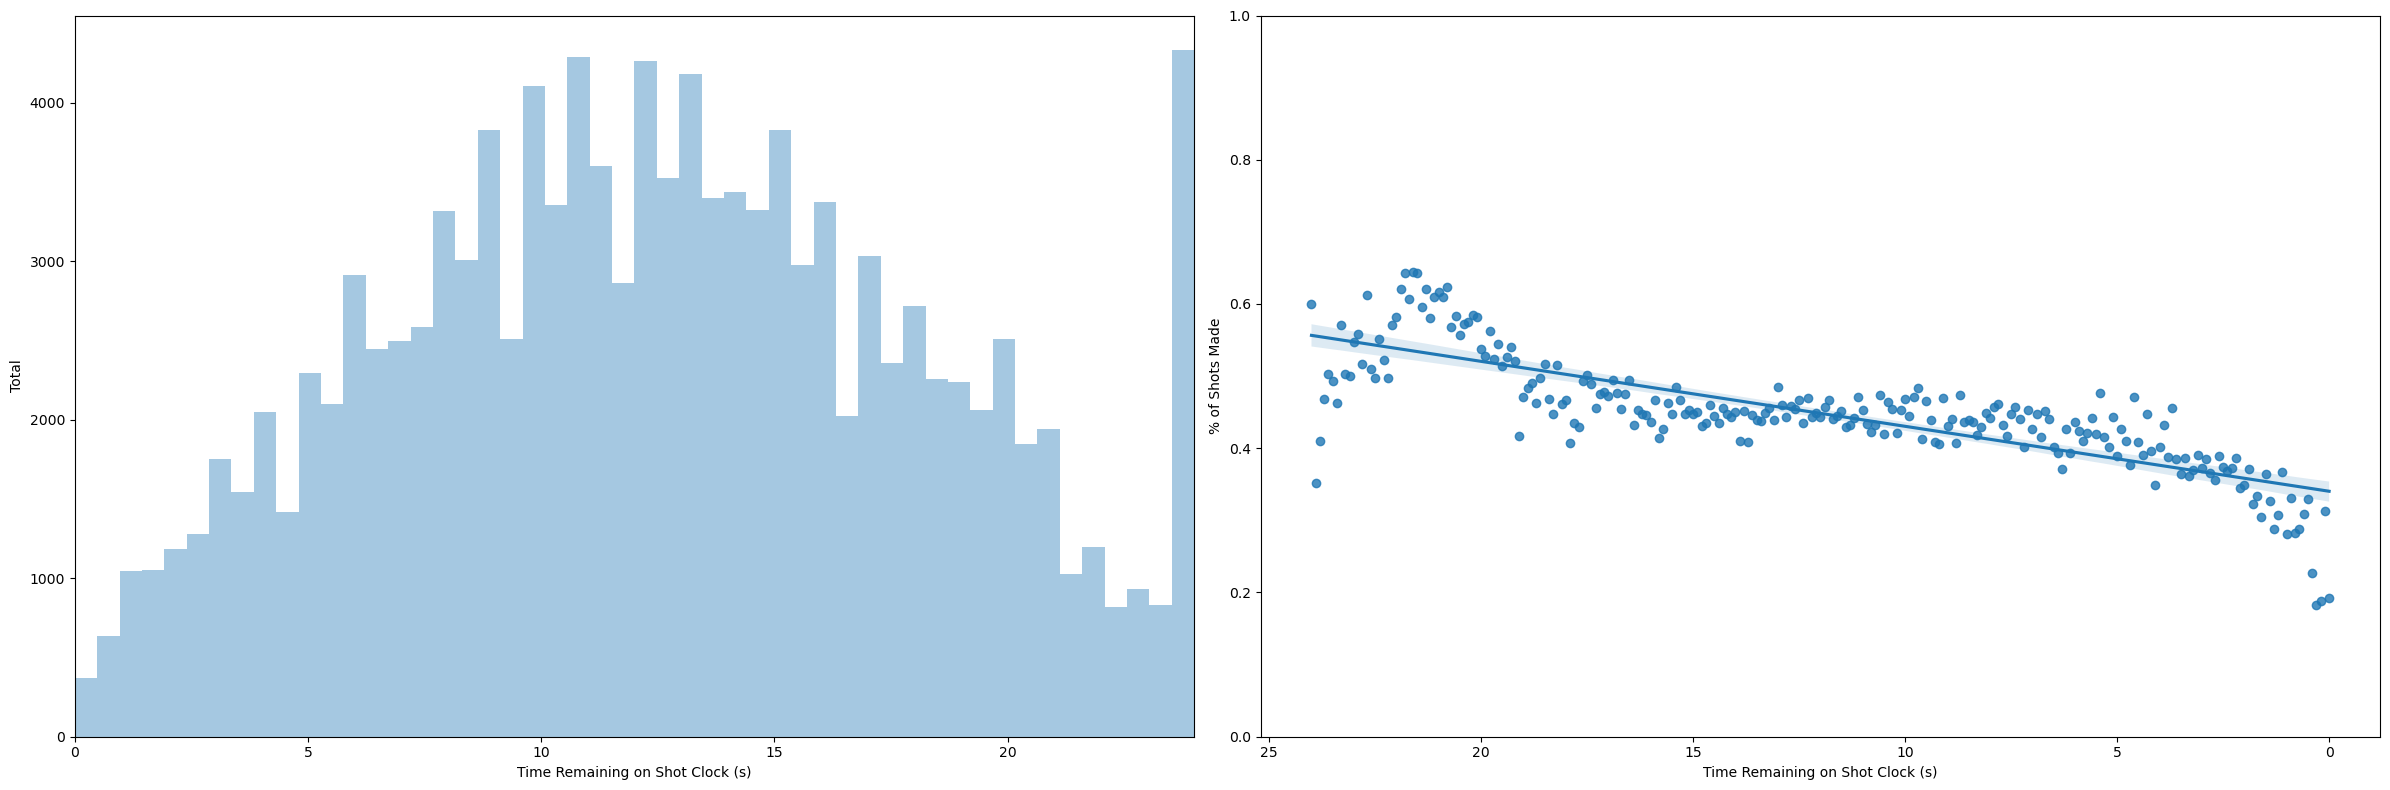

In [18]:
fig, axarr = plt.subplots(1, 2, figsize=(24, 8))
sns.distplot(data["SHOT_CLOCK"].dropna(), kde=False, ax=axarr[0])
axarr[0].set_xlabel("Time Remaining on Shot Clock (s)")
axarr[0].set_ylabel("Total")
axarr[0].set_xlim((0, 24))
shot_clock = pd.crosstab(data["SHOT_CLOCK"], data["FGM"]).reset_index()
shot_clock["Success_Rate"] = shot_clock[1] / (shot_clock[0] + shot_clock[1])
sns.regplot(shot_clock["SHOT_CLOCK"], shot_clock["Success_Rate"], ax=axarr[1])
axarr[1].set_ylim((0, 1))
axarr[1].invert_xaxis()
axarr[1].set_xlabel("Time Remaining on Shot Clock (s)")
axarr[1].set_ylabel("% of Shots Made")
fig.tight_layout()

C:\Users\madha\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\madha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


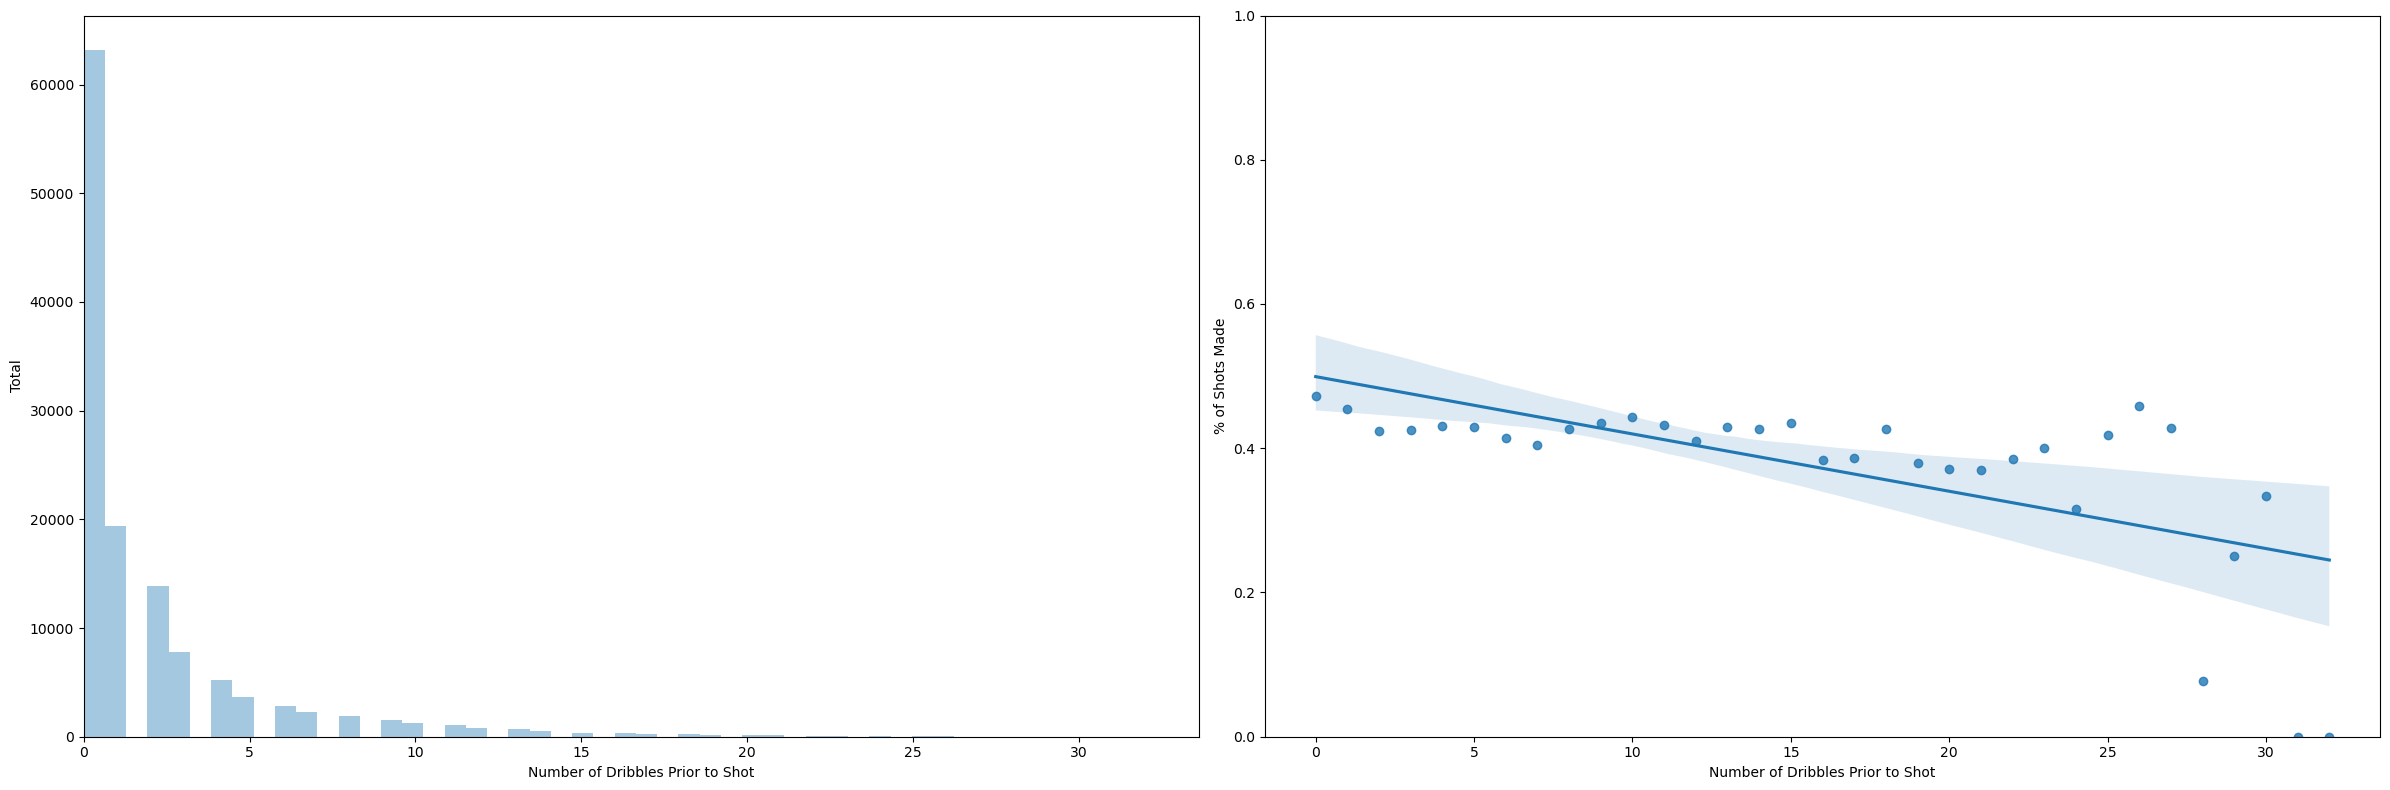

In [19]:
fig, axarr = plt.subplots(1, 2, figsize=(24, 8))
sns.distplot(data["DRIBBLES"], kde=False, ax=axarr[0])
axarr[0].set_xlabel("Number of Dribbles Prior to Shot")
axarr[0].set_ylabel("Total")
axarr[0].set_xlim((0, axarr[0].get_xlim()[1]))
dribbles = pd.crosstab(data["DRIBBLES"], data["FGM"]).reset_index()
dribbles["Success_Rate"] = dribbles[1] / (dribbles[0] + dribbles[1])
sns.regplot(dribbles["DRIBBLES"], dribbles["Success_Rate"], ax=axarr[1])
axarr[1].set_ylim((0, 1))
axarr[1].set_xlabel("Number of Dribbles Prior to Shot")
axarr[1].set_ylabel("% of Shots Made")
fig.tight_layout()

C:\Users\madha\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\madha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


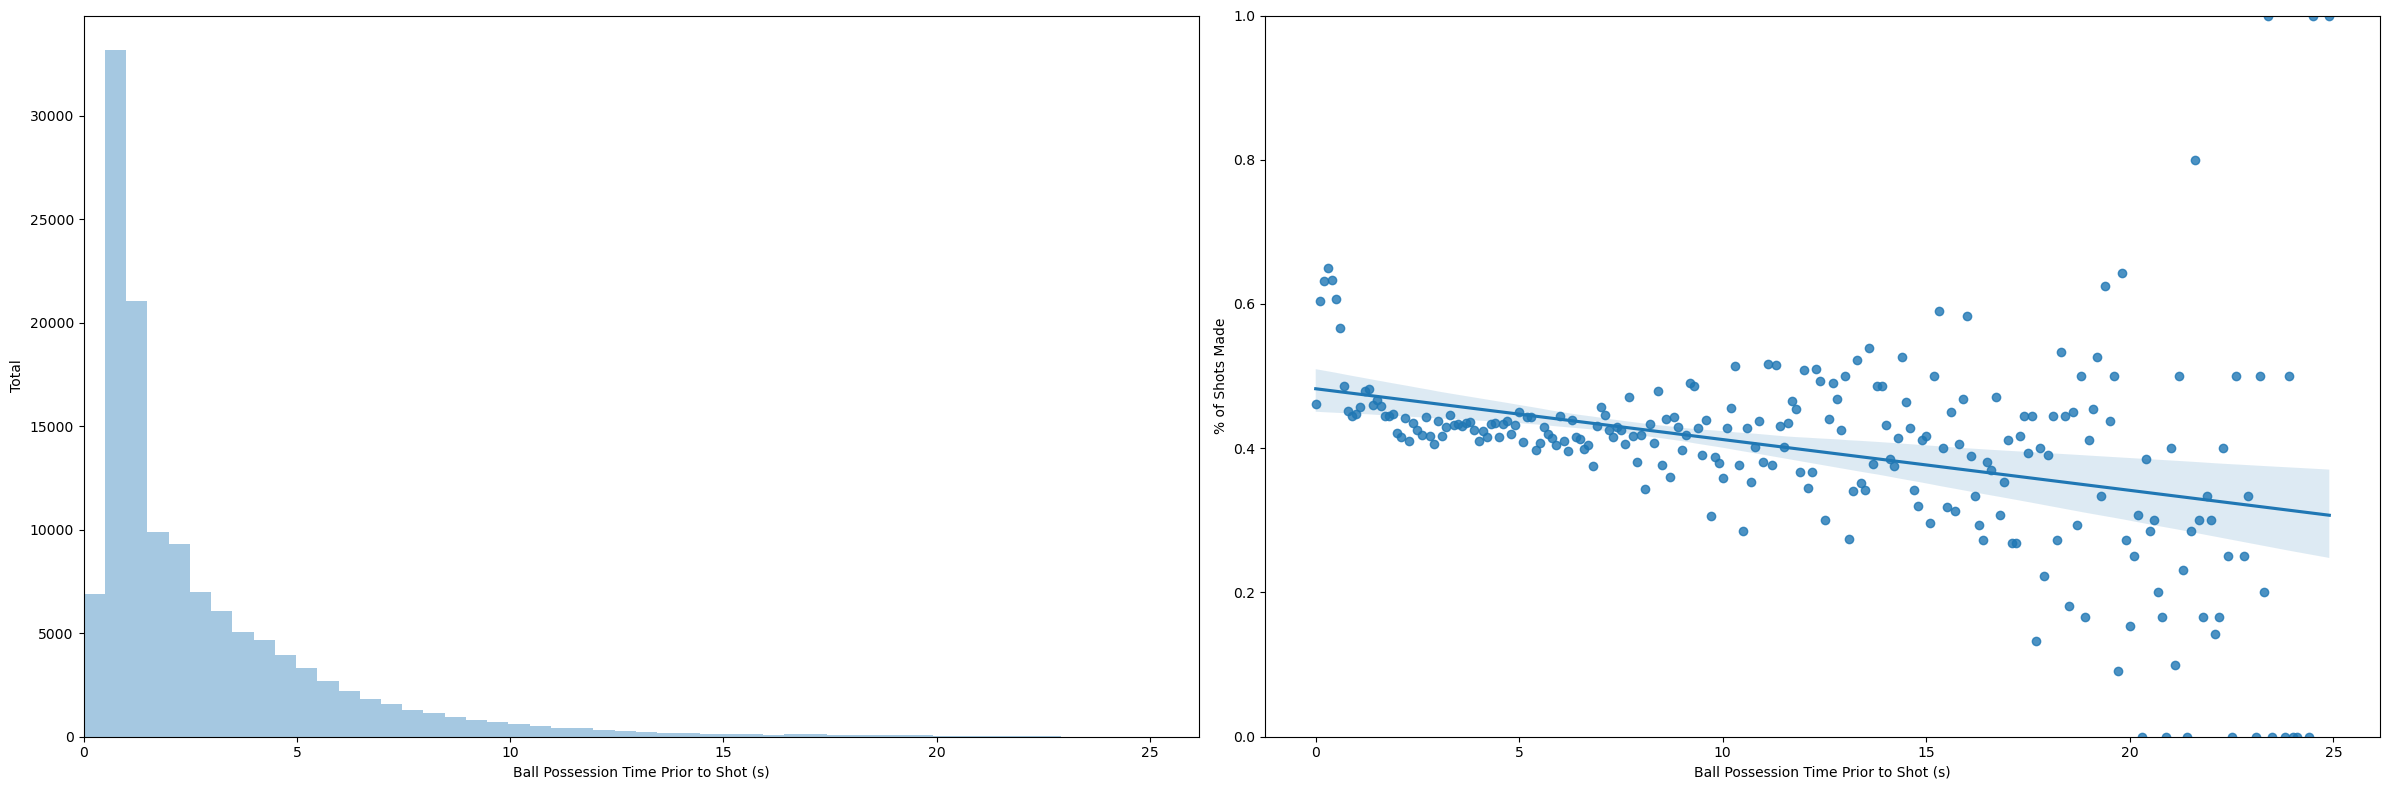

In [22]:
fig, axarr = plt.subplots(1, 2, figsize=(24, 8))
data["TOUCH_TIME"] = data["TOUCH_TIME"].clip(lower = 0)
sns.distplot(data["TOUCH_TIME"], kde=False, ax=axarr[0])
axarr[0].set_xlabel("Ball Possession Time Prior to Shot (s)")
axarr[0].set_ylabel("Total")
axarr[0].set_xlim((0, axarr[0].get_xlim()[1]))
touch_time = pd.crosstab(data["TOUCH_TIME"], data["FGM"]).reset_index()
touch_time["Success_Rate"] = touch_time[1] / (touch_time[0] + touch_time[1])
sns.regplot(touch_time["TOUCH_TIME"], touch_time["Success_Rate"], ax=axarr[1])
axarr[1].set_ylim((0, 1))
axarr[1].set_xlabel("Ball Possession Time Prior to Shot (s)")
axarr[1].set_ylabel("% of Shots Made")
fig.tight_layout()

C:\Users\madha\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\madha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


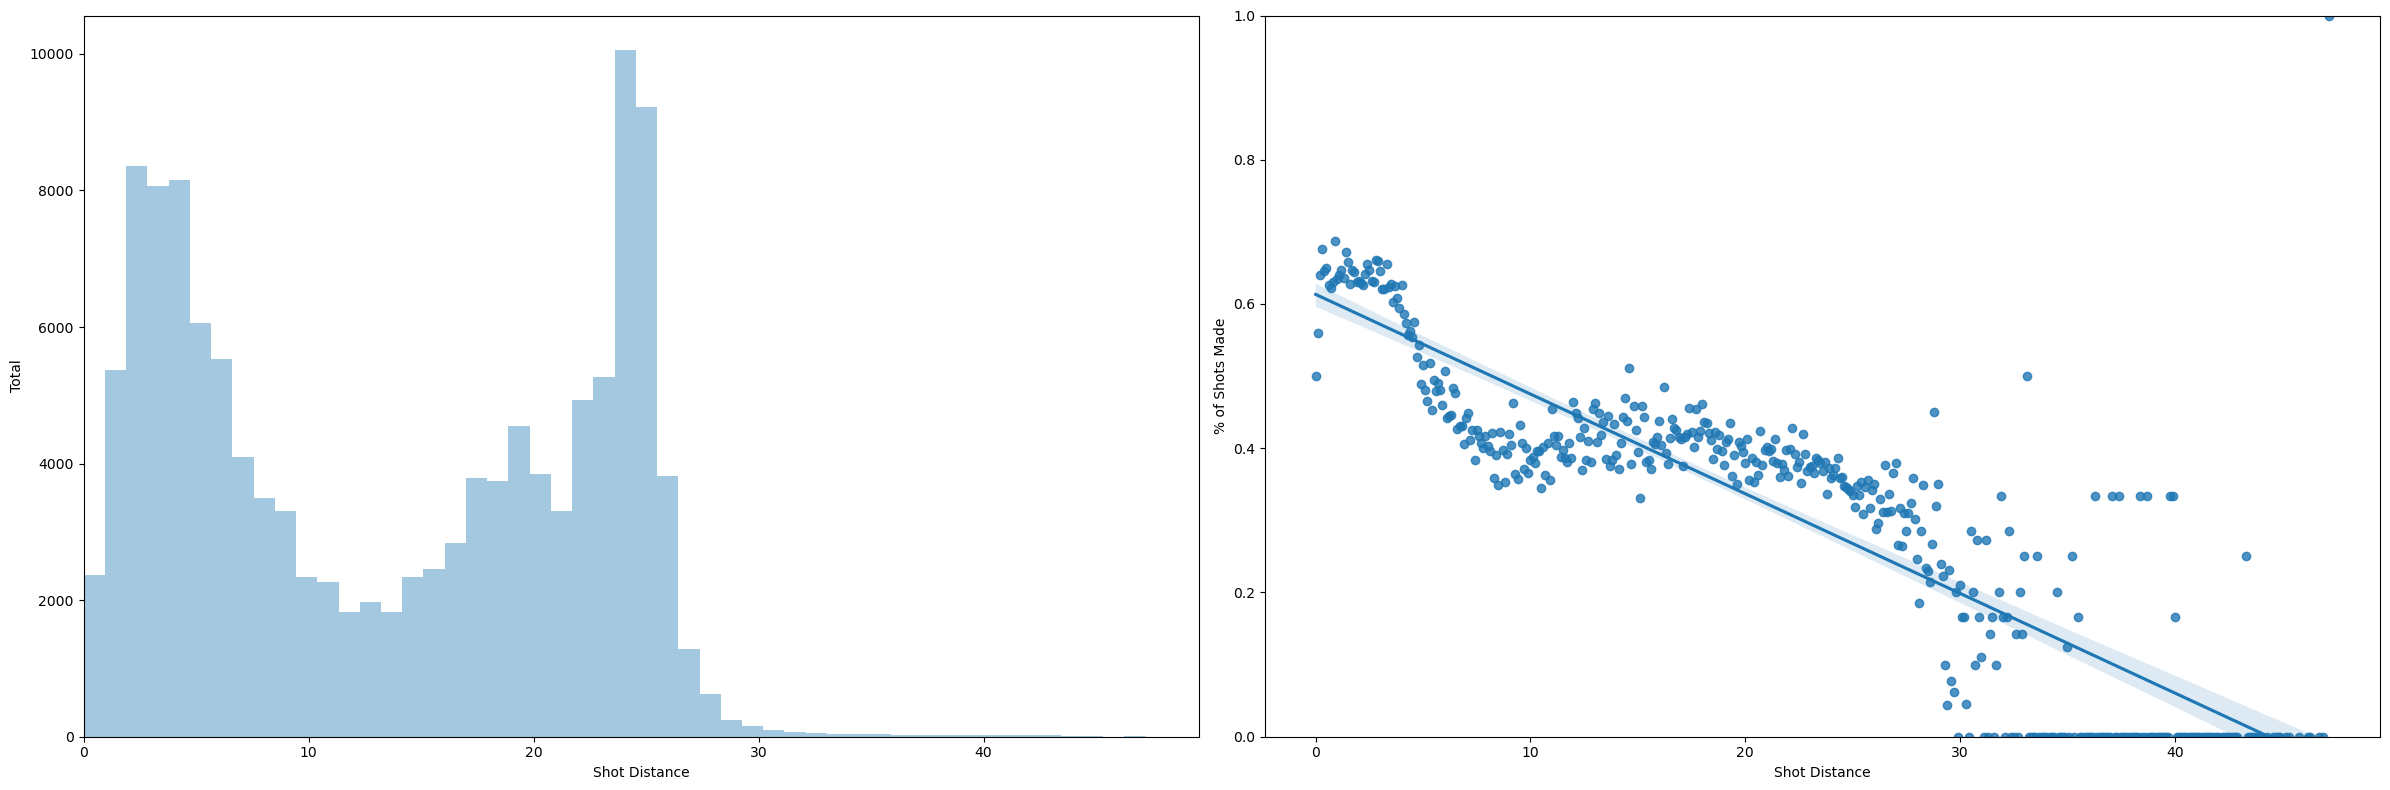

In [23]:
fig, axarr = plt.subplots(1, 2, figsize=(24, 8))
sns.distplot(data["SHOT_DIST"], kde=False, ax=axarr[0])
axarr[0].set_xlabel("Shot Distance")
axarr[0].set_ylabel("Total")
axarr[0].set_xlim((0, axarr[0].get_xlim()[1]))
shot_distance = pd.crosstab(data["SHOT_DIST"], data["FGM"]).reset_index()
shot_distance["Success_Rate"] = shot_distance[1] / (shot_distance[0] + shot_distance[1])
sns.regplot(shot_distance["SHOT_DIST"], shot_distance["Success_Rate"], ax=axarr[1])
axarr[1].set_ylim((0, 1))
axarr[1].set_xlabel("Shot Distance")
axarr[1].set_ylabel("% of Shots Made")
fig.tight_layout()

C:\Users\madha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


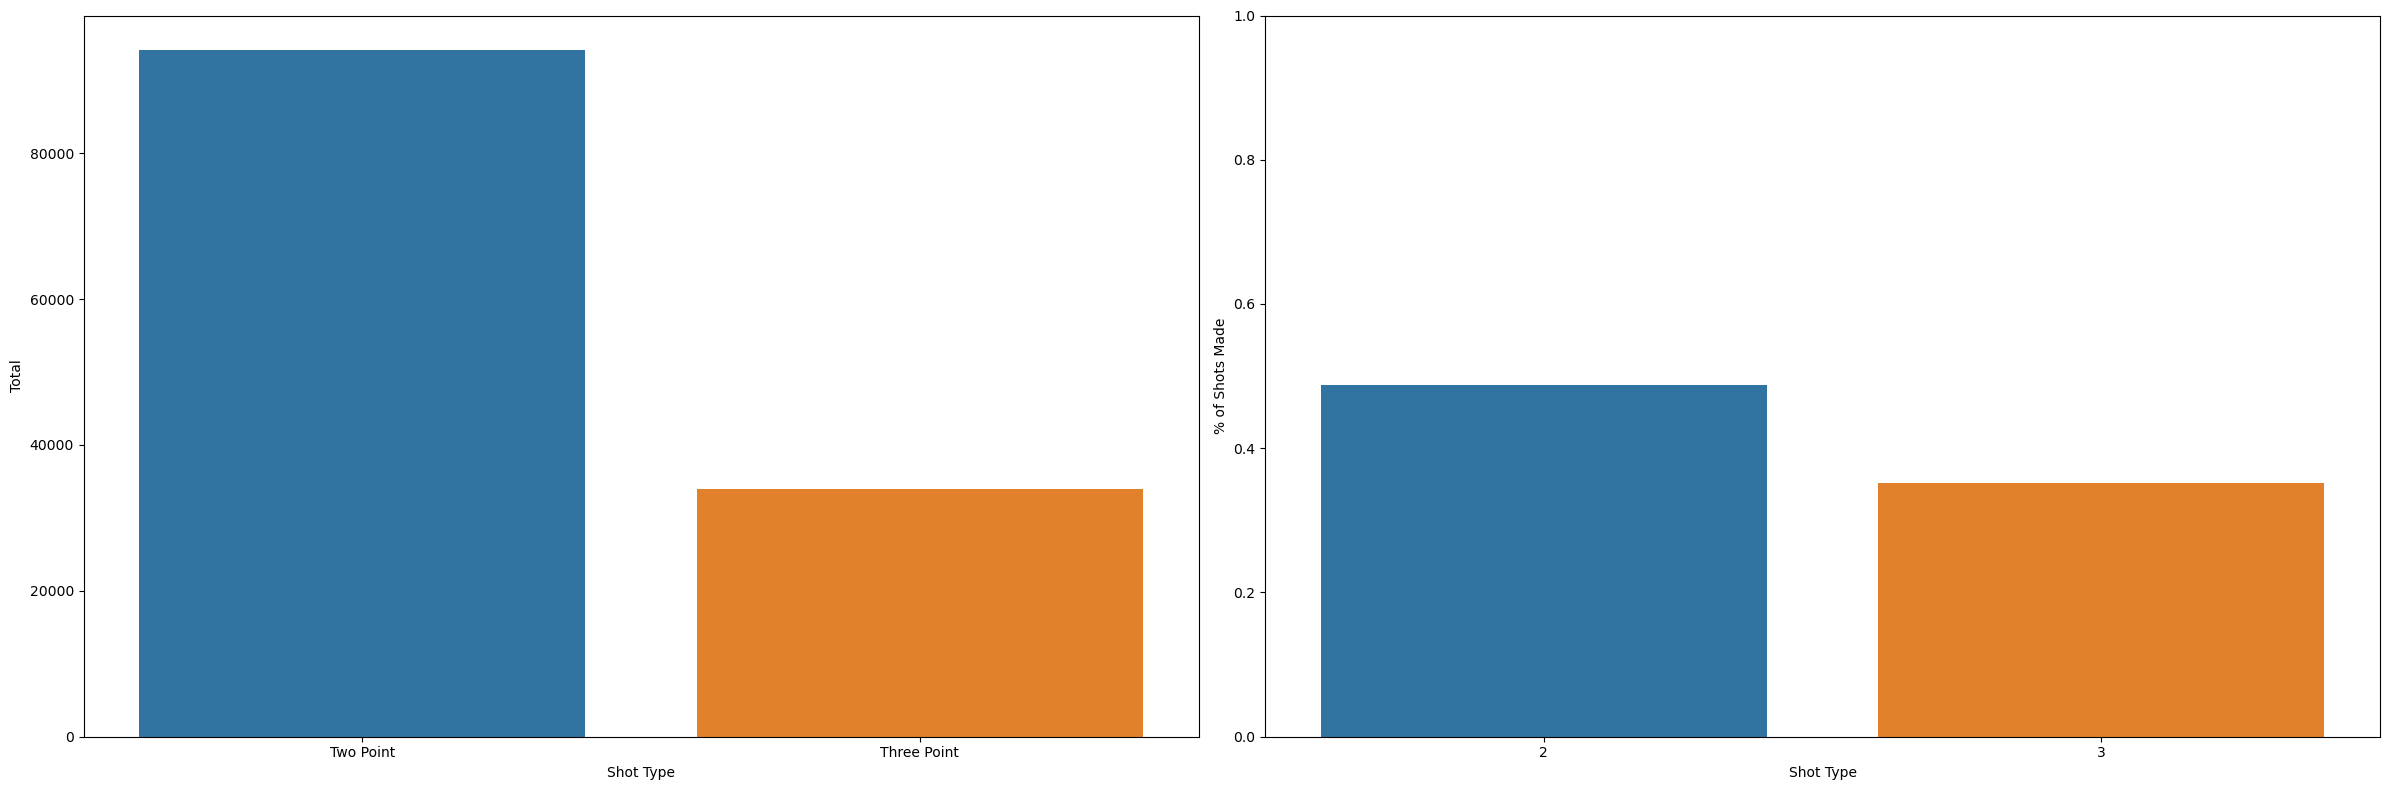

In [25]:
fig, axarr = plt.subplots(1, 2, figsize=(24, 8))
data["PTS_TYPE"] = data["PTS_TYPE"].clip(lower = 0)
sns.countplot(x="PTS_TYPE", data=data, ax=axarr[0])
axarr[0].set_xticklabels(["Two Point", "Three Point"])
axarr[0].set_xlabel("Shot Type")
axarr[0].set_ylabel("Total")
shot_type = pd.crosstab(data["PTS_TYPE"], data["FGM"]).reset_index()
shot_type["Success_Rate"] = shot_type[1] / (shot_type[0] + shot_type[1])
sns.barplot(shot_type["PTS_TYPE"], shot_type["Success_Rate"], ax=axarr[1])
axarr[1].set_ylim((0, 1))
axarr[1].set_xlabel("Shot Type")
axarr[1].set_ylabel("% of Shots Made")
fig.tight_layout()

C:\Users\madha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


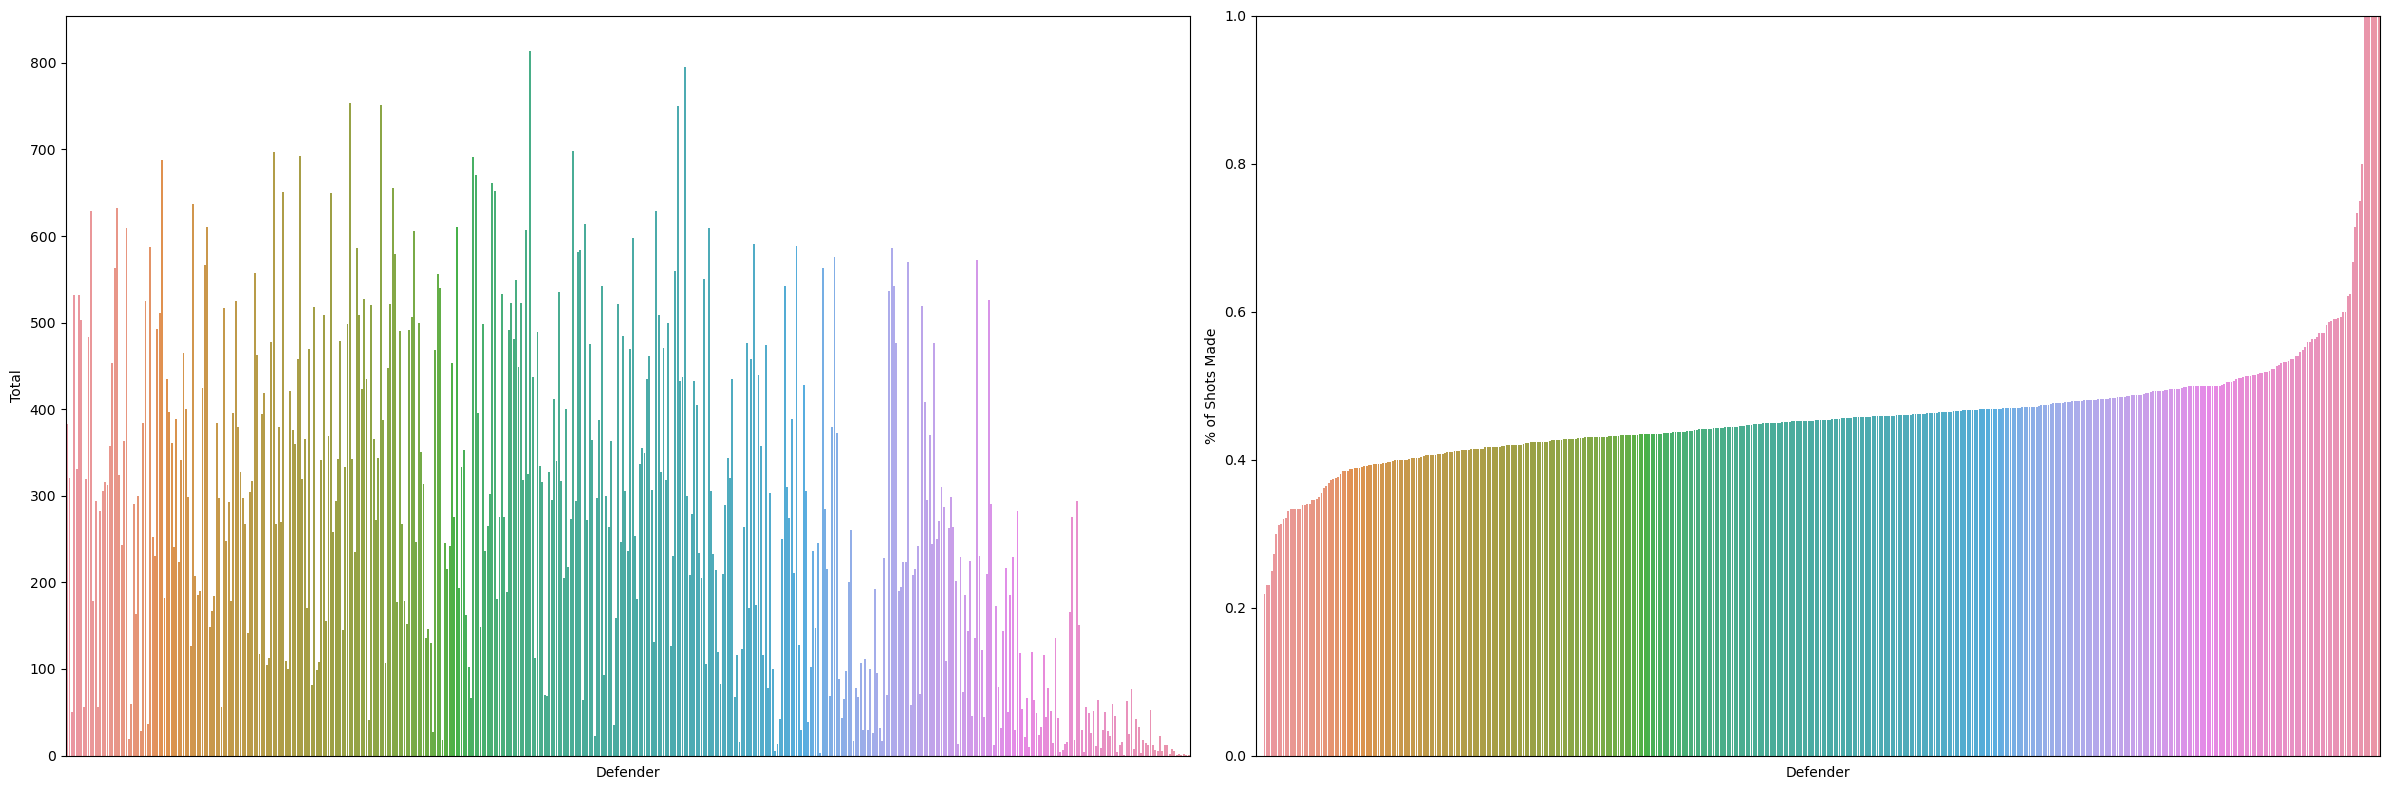

In [26]:
fig, axarr = plt.subplots(1, 2, figsize=(24, 8))
sns.countplot(x="CLOSEST_DEFENDER", data=data, ax=axarr[0])
axarr[0].get_xaxis().set_ticks([])
axarr[0].set_xticklabels("")
axarr[0].set_xlabel("Defender")
axarr[0].set_ylabel("Total")
defender = pd.crosstab(data["CLOSEST_DEFENDER"], data["FGM"]).reset_index()
defender["Success_Rate"] = defender[1] / (defender[0] + defender[1])
defender.sort_values("Success_Rate", inplace=True)
sns.barplot(defender["CLOSEST_DEFENDER"], 
            defender["Success_Rate"], 
            ax=axarr[1])
axarr[1].get_xaxis().set_ticks([])
axarr[1].set_xticklabels("")
axarr[1].set_ylim((0, 1))
axarr[1].set_xlabel("Defender")
axarr[1].set_ylabel("% of Shots Made")
fig.tight_layout()

C:\Users\madha\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\madha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


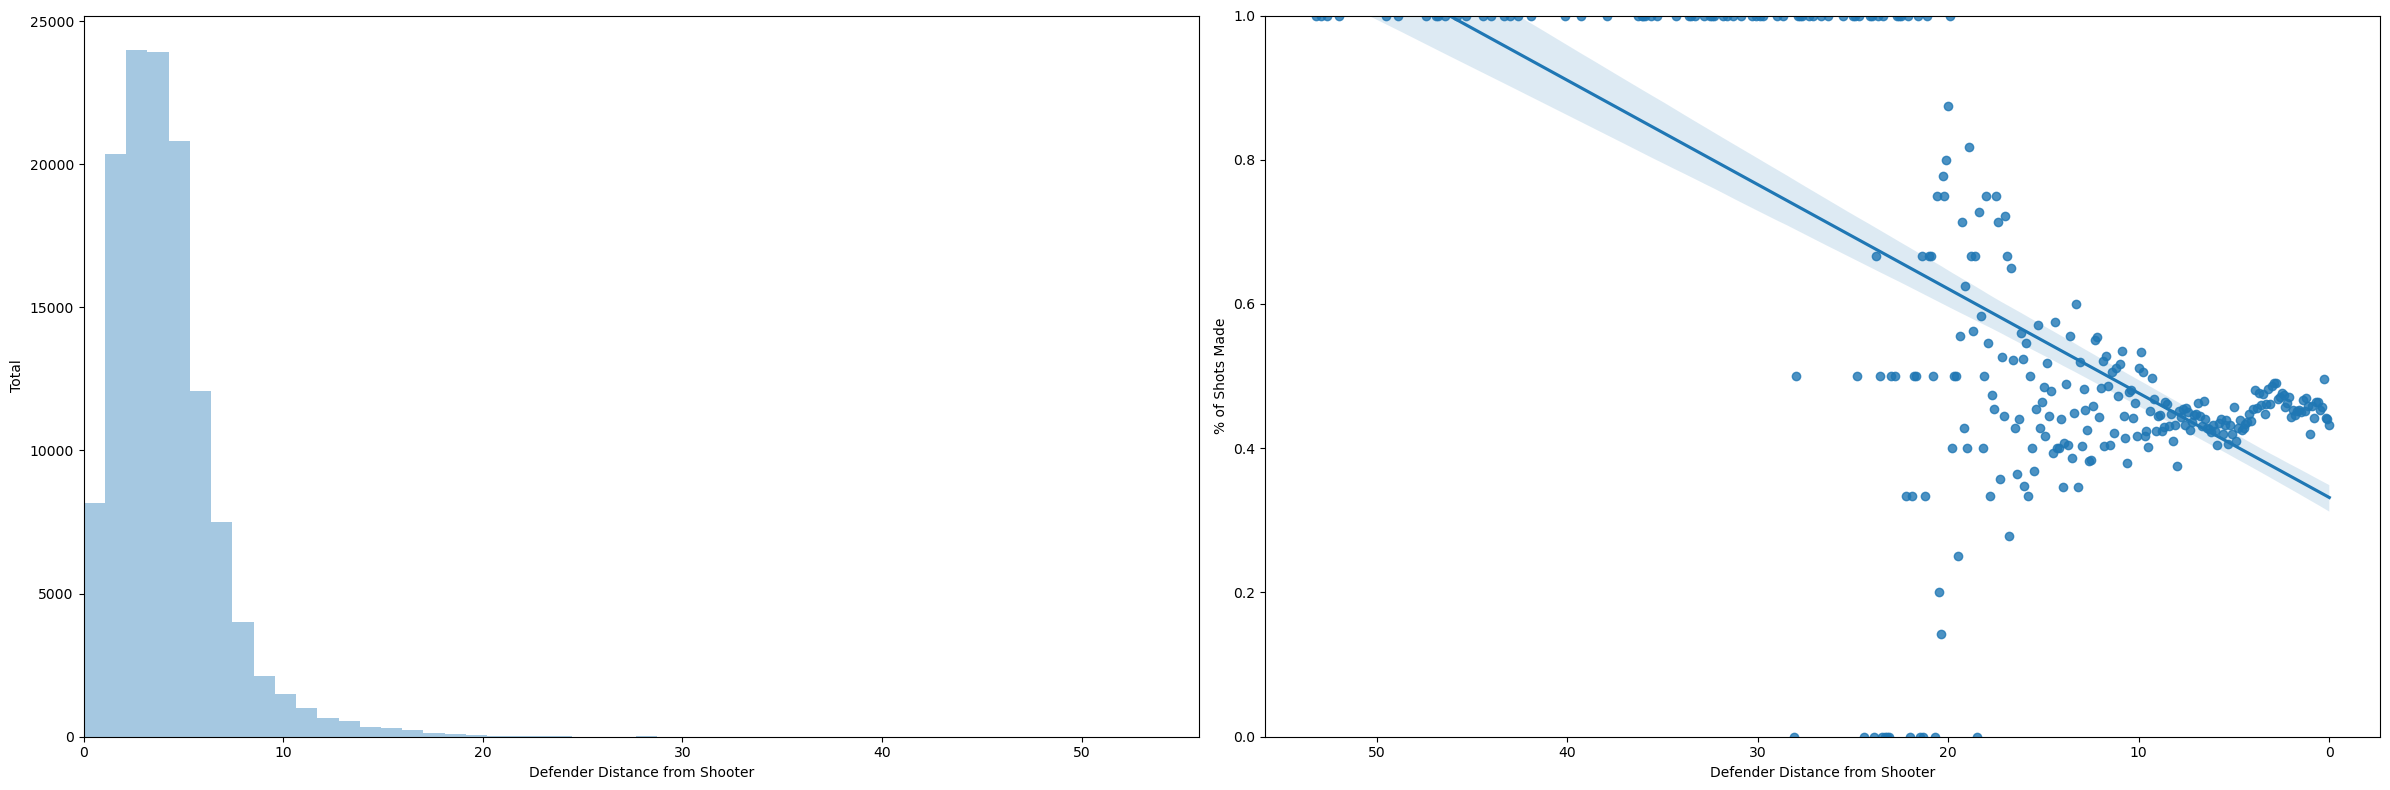

In [27]:
fig, axarr = plt.subplots(1, 2, figsize=(24, 8))
sns.distplot(data["CLOSE_DEF_DIST"], kde=False, ax=axarr[0])
axarr[0].set_xlabel("Defender Distance from Shooter")
axarr[0].set_ylabel("Total")
axarr[0].set_xlim((0, axarr[0].get_xlim()[1]))
defender_distance = pd.crosstab(data["CLOSE_DEF_DIST"], data["FGM"]).reset_index()
defender_distance["Success_Rate"] = (defender_distance[1] / 
                                     (defender_distance[0] + 
                                      defender_distance[1]))
sns.regplot(defender_distance["CLOSE_DEF_DIST"], 
            defender_distance["Success_Rate"], 
            ax=axarr[1])
axarr[1].invert_xaxis()
axarr[1].set_ylim((0, 1))
axarr[1].set_xlabel("Defender Distance from Shooter")
axarr[1].set_ylabel("% of Shots Made")
fig.tight_layout()

C:\Users\madha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


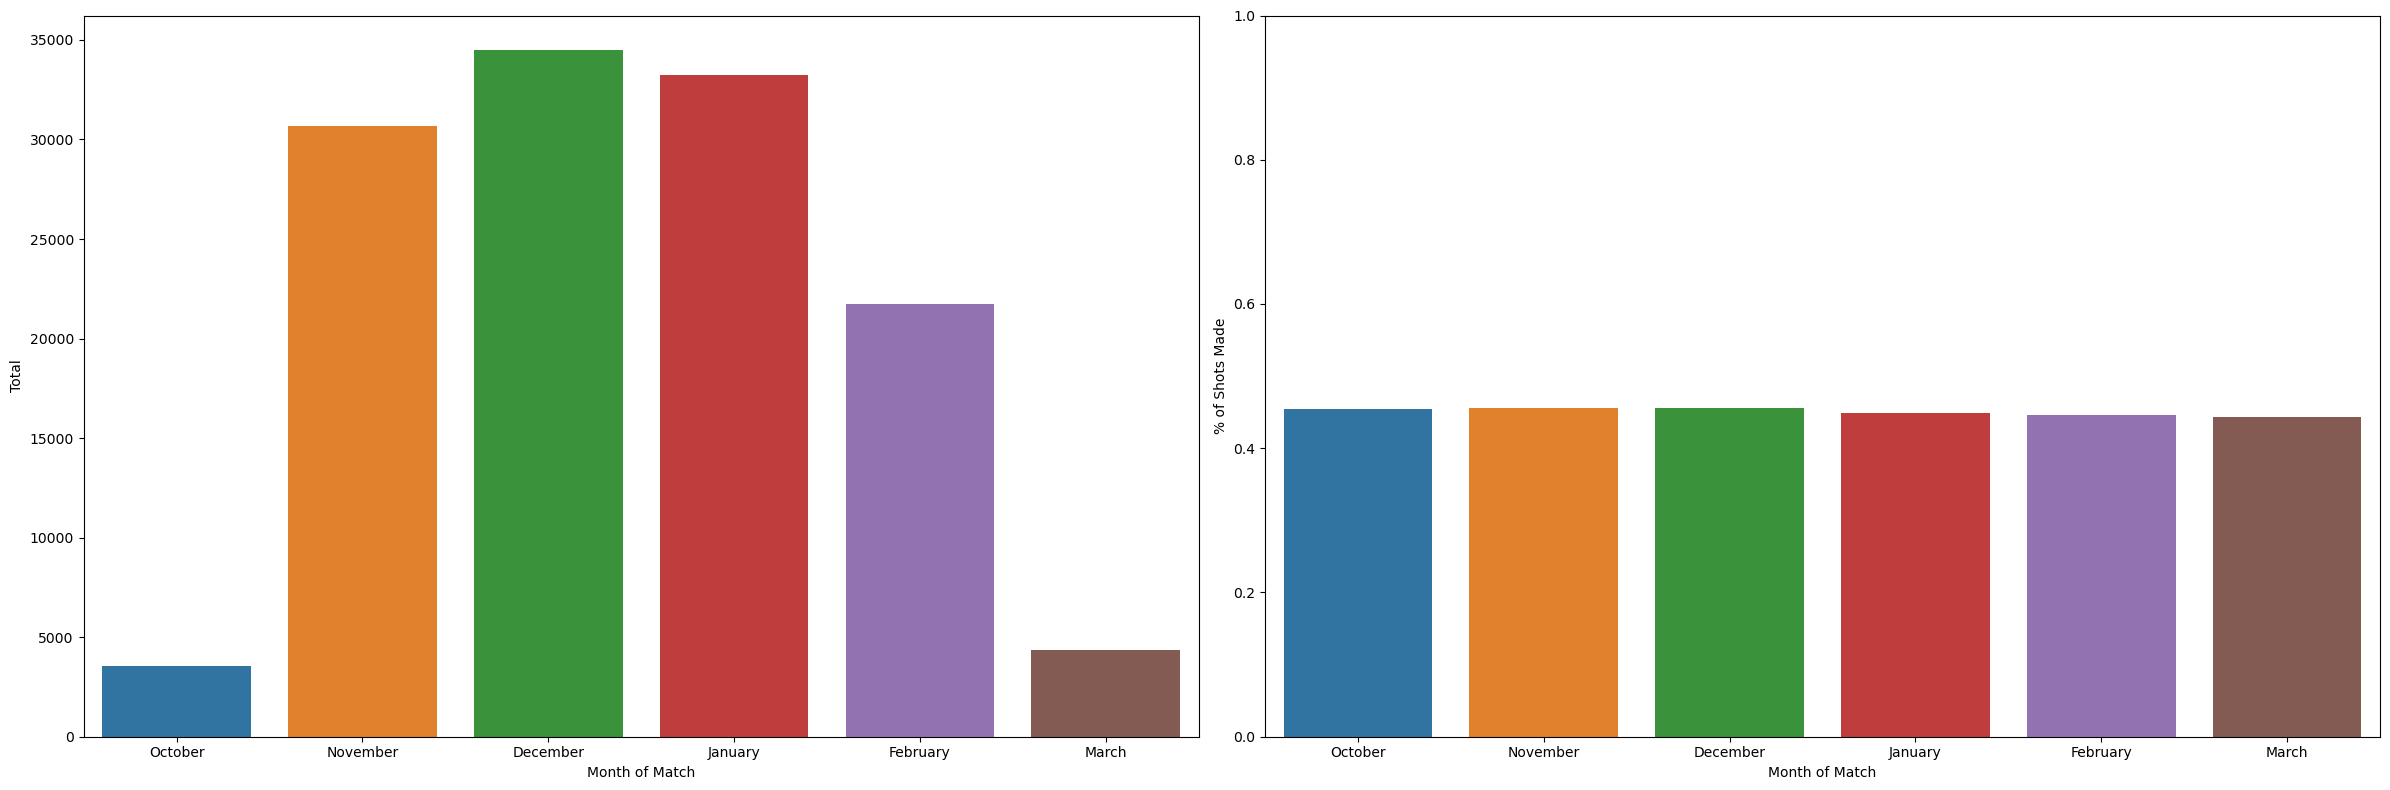

In [28]:
fig, axarr = plt.subplots(1, 2, figsize=(24, 8))
sns.countplot(x="MONTH", data=data, order=[10, 11, 12, 1, 2, 3], ax=axarr[0])
axarr[0].set_xticklabels(["October", 
                          "November", 
                          "December", 
                          "January", 
                          "February", 
                          "March"])
axarr[0].set_xlabel("Month of Match")
axarr[0].set_ylabel("Total")
month = pd.crosstab(data["MONTH"], data["FGM"])
month["Success_Rate"] = month[1] / (month[0] + month[1])
month = month.reindex([10, 11, 12, 1, 2, 3]).reset_index().reset_index()
sns.barplot(month["index"], 
            month["Success_Rate"], 
            ax=axarr[1])
axarr[1].set_ylim((0, 1))
axarr[1].set_xticklabels(["October", 
                          "November", 
                          "December", 
                          "January", 
                          "February", 
                          "March"])
axarr[1].set_xlabel("Month of Match")
axarr[1].set_ylabel("% of Shots Made")
fig.tight_layout()

C:\Users\madha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


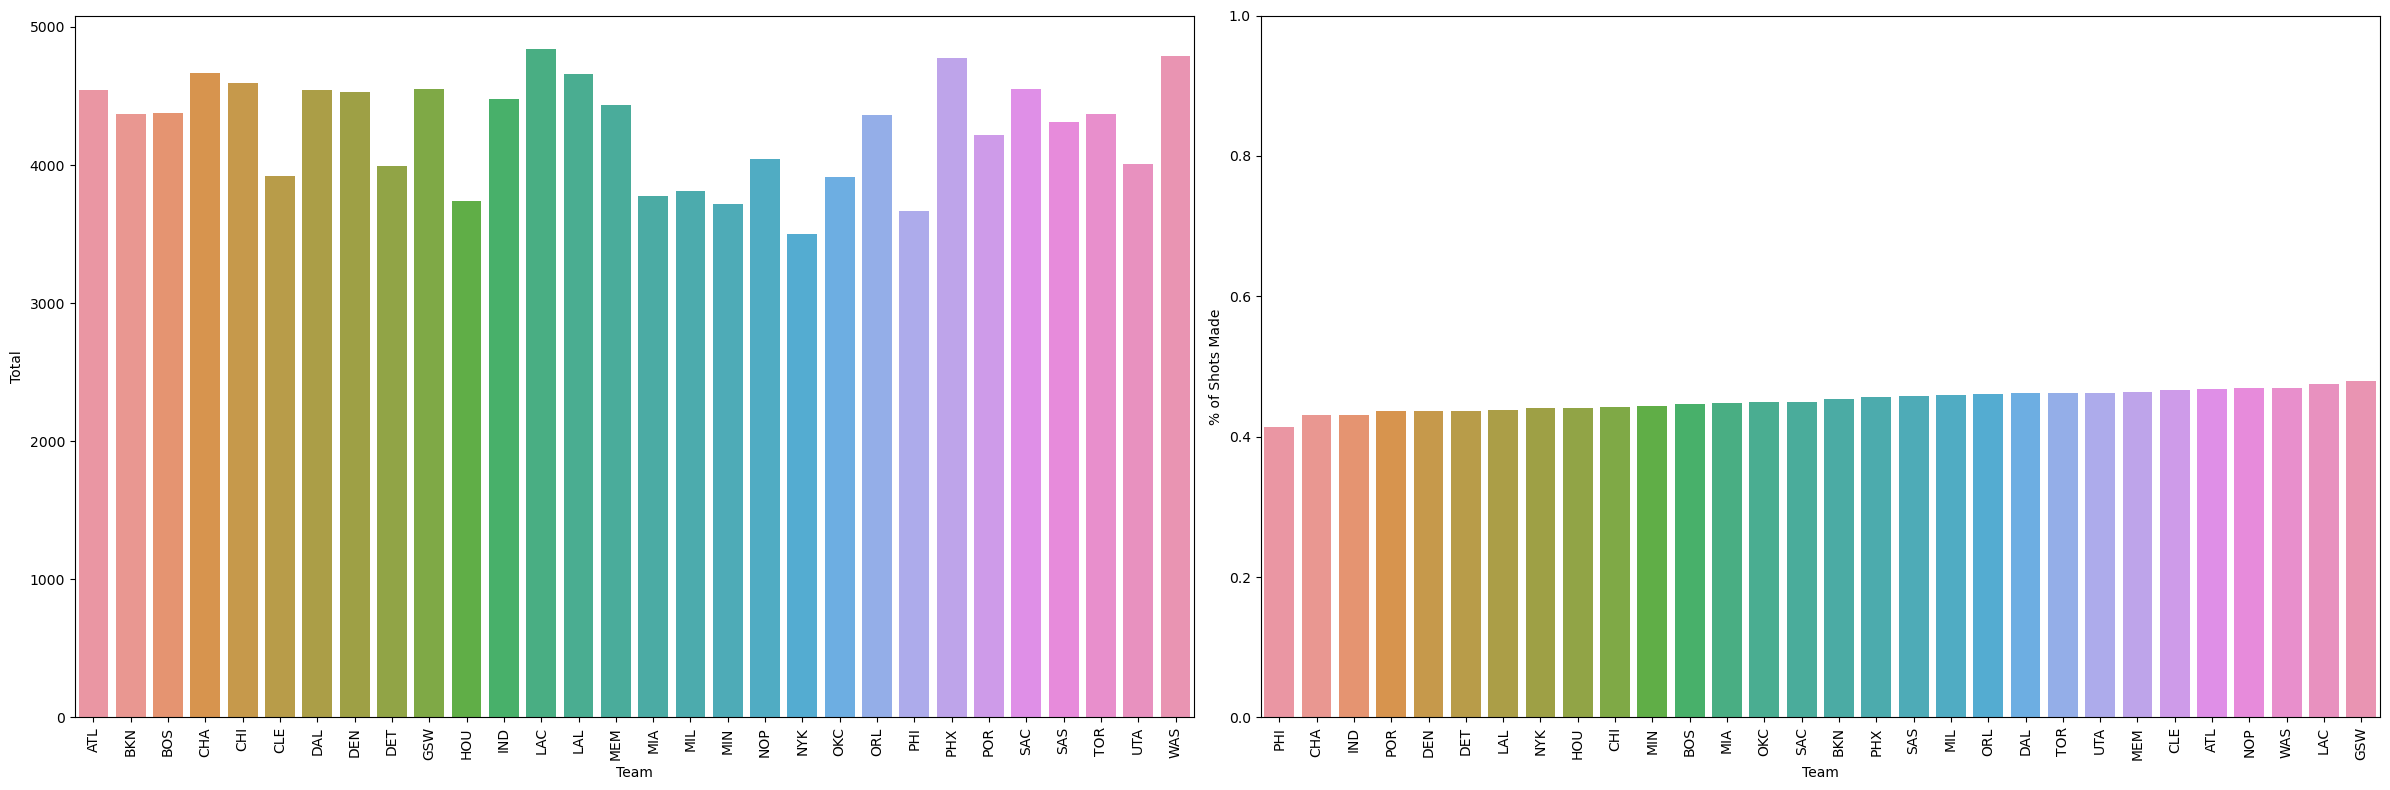

In [29]:
fig, axarr = plt.subplots(1, 2, figsize=(24, 8))
sns.countplot(x="TEAM", 
              data=data, 
              order=data["TEAM"].value_counts().sort_index().index, 
              ax=axarr[0])
axarr[0].set_xticklabels(labels=axarr[0].get_xticklabels(), rotation=90)
axarr[0].set_xlabel("Team")
axarr[0].set_ylabel("Total")
team = pd.crosstab(data["TEAM"], data["FGM"]).reset_index()
team["Success_Rate"] = team[1] / (team[0] + team[1])
team.sort_values(by="Success_Rate", inplace=True)
sns.barplot(team["TEAM"], team["Success_Rate"], ax=axarr[1])
axarr[1].set_ylim((0, 1))
axarr[1].set_xticklabels(labels=axarr[1].get_xticklabels(), rotation=90)
axarr[1].set_xlabel("Team")
axarr[1].set_ylabel("% of Shots Made")
fig.tight_layout()

C:\Users\madha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


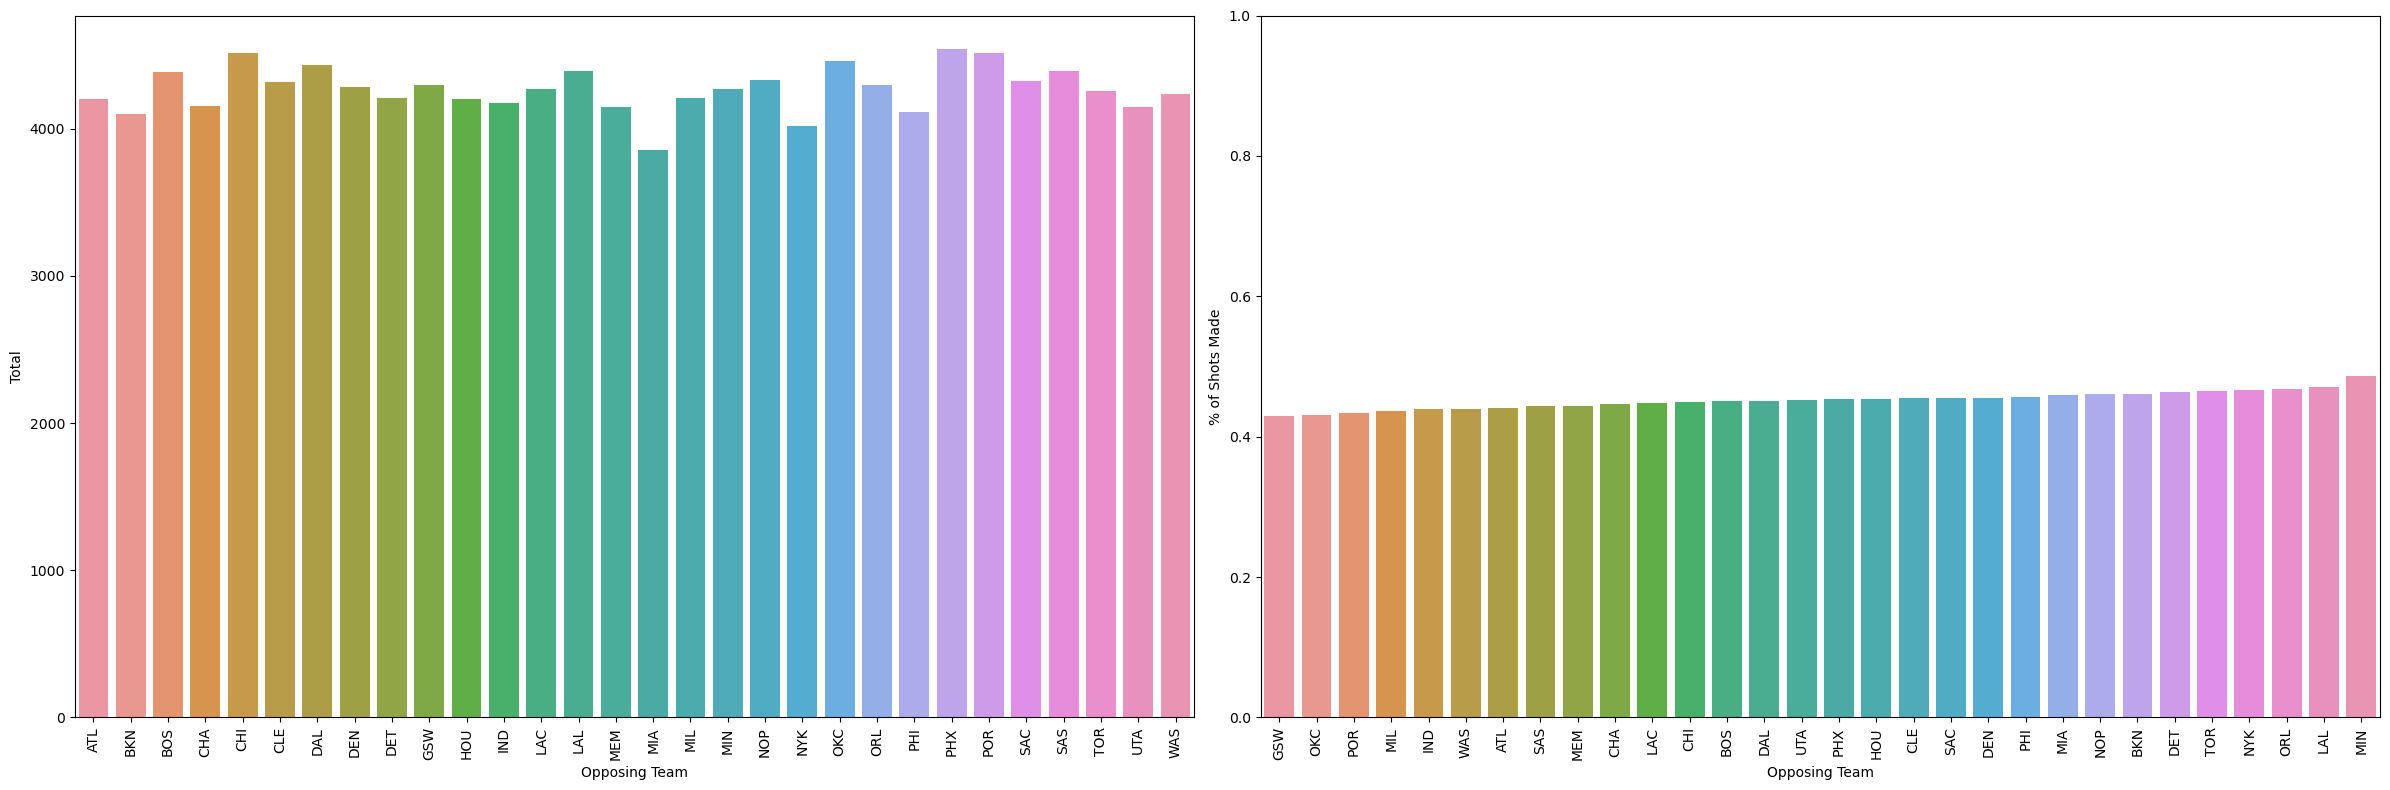

In [30]:
fig, axarr = plt.subplots(1, 2, figsize=(24, 8))
sns.countplot(x="OPPOSING_TEAM", 
              data=data, 
              order=data["OPPOSING_TEAM"].value_counts().sort_index().index, 
              ax=axarr[0])
axarr[0].set_xticklabels(labels=axarr[0].get_xticklabels(), rotation=90)
axarr[0].set_xlabel("Opposing Team")
axarr[0].set_ylabel("Total")
opponent = pd.crosstab(data["OPPOSING_TEAM"], data["FGM"]).reset_index()
opponent["Success_Rate"] = opponent[1] / (opponent[0] + opponent[1])
opponent.sort_values(by="Success_Rate", inplace=True)
sns.barplot(opponent["OPPOSING_TEAM"], opponent["Success_Rate"], ax=axarr[1])
axarr[1].set_ylim((0, 1))
axarr[1].set_xticklabels(labels=axarr[1].get_xticklabels(), rotation=90)
axarr[1].set_xlabel("Opposing Team")
axarr[1].set_ylabel("% of Shots Made")
fig.tight_layout()

C:\Users\madha\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\madha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


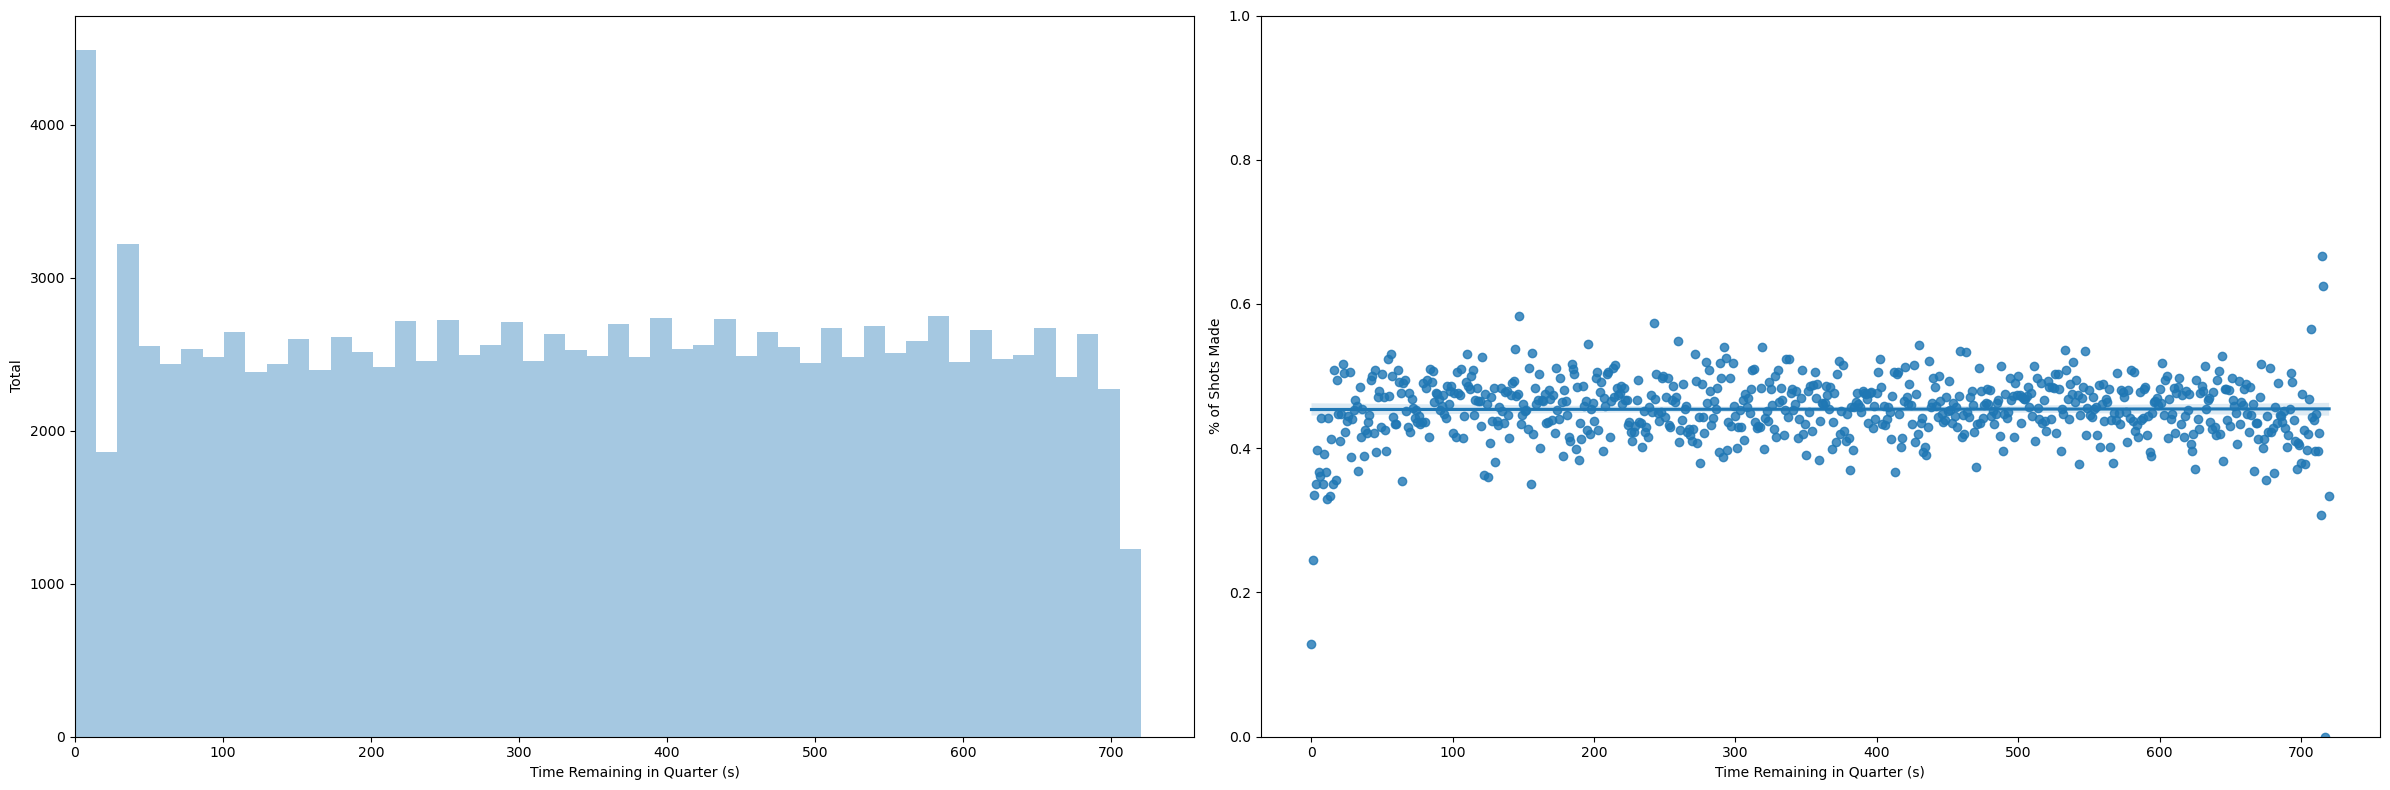

In [31]:
fig, axarr = plt.subplots(1, 2, figsize=(24, 8))
sns.distplot(data["PERIOD_CLOCK"], kde=False, ax=axarr[0])
axarr[0].set_xlim((0, axarr[0].get_xlim()[1]))
axarr[0].set_xlabel("Time Remaining in Quarter (s)")
axarr[0].set_ylabel("Total")
quarter_clock = pd.crosstab(data["PERIOD_CLOCK"], data["FGM"]).reset_index()
quarter_clock["Success_Rate"] = quarter_clock[1] / (quarter_clock[0] + quarter_clock[1])
sns.regplot(quarter_clock["PERIOD_CLOCK"], quarter_clock["Success_Rate"], ax=axarr[1])
axarr[1].set_ylim((0, 1))
axarr[1].set_xlabel("Time Remaining in Quarter (s)")
axarr[1].set_ylabel("% of Shots Made")
fig.tight_layout()

In [32]:
data["SHOT_CLOCK"].fillna(data["SHOT_CLOCK"].mean(), inplace=True)
ml_data = data[["FGM", 
                "FINAL_MARGIN", 
                "SHOT_NUMBER", 
                "PERIOD", 
                "SHOT_CLOCK", 
                "DRIBBLES", 
                "TOUCH_TIME", 
                "SHOT_DIST", 
                "PTS_TYPE", 
                "CLOSE_DEF_DIST"]]
X_data = ml_data.drop("FGM", axis=1)
y_data = ml_data["FGM"]
X_train, X_test, y_train, y_test = train_test_split(X_data, 
                                                    y_data, 
                                                    test_size=0.2, 
                                                    random_state=0)

In [33]:
cv_model = GridSearchCV(GradientBoostingClassifier(random_state=0), 
                        param_grid={"learning_rate": np.logspace(-3, -1, 3)}).fit(X_train, 
                                                                                  y_train)
cv_model.best_params_

{'learning_rate': 0.1}

In [34]:
model = GradientBoostingClassifier(random_state=0).fit(X_train, y_train)
model.score(X_test, y_test)

0.6193878347778559

In [ ]:
features = X_train.columns
feature_significance = pd.DataFrame({"Feature": features, 
                                     "Importance": model.feature_importances_})
feature_significance.sort_values("Importance", 
                                 ascending=False, 
                                 inplace=True)
feature_significance.reset_index(drop=True, inplace=True)
feature_significance.index += 1
feature_significance.at[1, "Feature"] = "Shot Distance"
feature_significance.at[2, "Feature"] = "Defender Distance from Shooter"
feature_significance.at[3, "Feature"] = "Ball Possession Time Prior to Shot (s)"
feature_significance.at[4, "Feature"] = "Final Margin"
feature_significance.at[5, "Feature"] = "Time Remaining on Shot Clock (s)"
feature_significance.at[6, "Feature"] = "Number of Dribbles Prior to Shot"
feature_significance.at[7, "Feature"] = "Shot Type"
feature_significance.at[8, "Feature"] = "Shot Number"
feature_significance.at[9, "Feature"] = "Quarter"
ax = sns.barplot(feature_significance["Importance"], feature_significance["Feature"], orient="h")

In [ ]:
fig, axarr =plt.subplots(3, 3, figsize=(24, 16))
for feature in range(len(features)):
    if feature < 3:
        axis = axarr[0][feature]
    elif feature < 6:
        axis = axarr[1][feature-3]
    else:
        axis = axarr[2][feature-6]
    sns.regplot(partial_dependence(model, 
                                   [feature], 
                                   X=X_train)[1][0], 
                partial_dependence(model, 
                                   [feature], 
                                   X=X_train)[0][0], 
                ax=axis)
    axis.set_ylim((-1, 1))
axarr[0][0].set_xlabel("Final Margin")
axarr[0][1].set_xlabel("In-Game Shot Number")
axarr[0][2].set_xlabel("Quarter")
axarr[1][0].invert_xaxis()
axarr[1][0].set_xlabel("Time Remaining on Shot Clock (s)")
axarr[1][1].set_xlabel("Number of Dribbles Prior to Shot")
axarr[1][2].set_xlabel("Ball Possession Time Prior to Shot (s)")
axarr[2][0].set_xlabel("Shot Distance")
axarr[2][1].set_xlabel("Shot Type")
axarr[2][2].set_xlabel("Defender Distance from Shooter")

# Best defenders

In [35]:
import pandas as pd
import numpy as np
import pylab as P
%matplotlib inline


In [46]:
# import data
shot_df = pd.read_csv('shot_logs.csv', header=0)

# defenders
defender_df = pd.concat([shot_df['CLOSEST_DEFENDER_PLAYER_ID'], shot_df['CLOSEST_DEFENDER']], axis=1, keys=['PLAYER_ID', 'PLAYER'])
defender_df = defender_df.drop_duplicates()

# shooters
shooter_df = pd.concat([shot_df['player_id'], shot_df['player_name']], axis=1, keys=['PLAYER_ID', 'PLAYER'])
shooter_df = shooter_df.drop_duplicates()

In [47]:
defender_df

,PLAYER_ID,PLAYER
0,101187,"Anderson, Alan"
1,202711,"Bogdanovic, Bojan"
3,203900,"Brown, Markel"
4,201152,"Young, Thaddeus"
5,101114,"Williams, Deron"
...,...,...
74976,203998,"Caboclo, Bruno"
79778,203961,"Moreland, Eric"
90592,203944,"Randle, Julius"
100170,203495,"Ledo, Ricky"


In [39]:
# FG%
for index, row in shooter_df.iterrows():
    this_id = row['PLAYER_ID']
    
    shooter_df.loc[ (shooter_df['PLAYER_ID'] == this_id), 'FGM']\
        = shot_df[ (shot_df['SHOT_RESULT'] == 'made') 
            & (shot_df['player_id'] == this_id)]['player_id'].count()
    
    shooter_df.loc[ (shooter_df['PLAYER_ID'] == this_id), 'FGA']\
        = shot_df[(shot_df['player_id'] == this_id)]['player_id'].count()
    
    shooter_df['FG%'] = shooter_df['FGM'] / shooter_df['FGA']

In [40]:
# DFG%
for index, row in defender_df.iterrows():
    this_id = row['PLAYER_ID']
    
    defender_df.loc[ (defender_df['PLAYER_ID'] == this_id), 'DFGM']\
        = shot_df[ (shot_df['SHOT_RESULT'] == 'made')\
          & (shot_df['CLOSEST_DEFENDER_PLAYER_ID'] == this_id)]['player_id'].count()
    
    defender_df.loc[ (defender_df['PLAYER_ID'] == this_id), 'DFGA']\
        = shot_df[(shot_df['CLOSEST_DEFENDER_PLAYER_ID'] == this_id)]['player_id'].count()
    
    defender_df['DFG%'] = defender_df['DFGM'] / defender_df['DFGA']
    
    # OFG% - average FG% of shooters this defender guards
    defender_dict = {}
    for shooter_index, shooter_row in shooter_df.iterrows():
        shooter_id = shooter_row['PLAYER_ID']
        shots_against_player = shot_df[ (shot_df['CLOSEST_DEFENDER_PLAYER_ID'] == this_id)\
                                        & (shot_df['player_id'] == shooter_id)]['player_id'].count()
        if shots_against_player > 0:
            defender_dict[shooter_id] = shots_against_player
    
    ofg = 0.0
    total_shots = defender_df[ (defender_df['PLAYER_ID'] == this_id)]['DFGA']
    for shooter, shots in defender_dict.items():
        ofg += shots/total_shots*shooter_df[ (shooter_df['PLAYER_ID'] == shooter)].iloc[0]['FG%']
    
    defender_df.loc[ (defender_df['PLAYER_ID'] == this_id), 'oFG%'] = ofg

In [41]:
defender_df['diff'] = defender_df['oFG%'] - defender_df['DFG%']
diff_df = defender_df.sort_values(by='diff', axis=0, ascending=False, inplace=False)
diff_df.head(10)

,PLAYER_ID,PLAYER,DFGM,DFGA,DFG%,oFG%,diff
68642,204054,"Dragic, Zoran",0.0,2.0,0.000000,0.423365,0.423365
32041,203564,"Lucas, Kalin",0.0,1.0,0.000000,0.414107,0.414107
100170,203495,"Ledo, Ricky",0.0,1.0,0.000000,0.338542,0.338542
4717,203108,"James, Bernard",7.0,32.0,0.218750,0.466325,0.247575
5487,203254,"Green, JaMychal",3.0,13.0,0.230769,0.453818,0.223049
12797,202327,"Udoh, Ekpe",3.0,13.0,0.230769,0.427311,0.196542
210,101126,"Robinson, Nate",27.0,99.0,0.272727,0.426686,0.153959
9079,203539,"Mekel, Gal",3.0,10.0,0.300000,0.451982,0.151982
11874,203540,"Datome, Gigi",1.0,4.0,0.250000,0.390776,0.140776
49345,201880,"Stiemsma, Greg",4.0,12.0,0.333333,0.472323,0.138989


## Best defender

In [42]:
diff_df[ (diff_df['DFGA'] > 300.0)].head(10)


,PLAYER_ID,PLAYER,DFGM,DFGA,DFG%,oFG%,diff
978,101106,"Bogut, Andrew",168.0,433.0,0.387991,0.479092,0.091101
440,203497,"Gobert, Rudy",192.0,489.0,0.392638,0.473431,0.080793
908,2754,"Allen, Tony",113.0,318.0,0.355346,0.436009,0.080663
1331,203460,"Roberson, Andre",120.0,320.0,0.375000,0.444953,0.069953
135,201579,"Hibbert, Roy",212.0,517.0,0.410058,0.478099,0.068041
272,203110,"Green, Draymond",301.0,751.0,0.400799,0.457991,0.057192
433,201586,"Ibaka, Serge",334.0,814.0,0.410319,0.466829,0.056510
1221,203076,"Davis, Anthony",247.0,609.0,0.405583,0.460045,0.054462
25,201149,"Noah, Joakim",267.0,632.0,0.422468,0.472019,0.049551
1895,202344,"Booker, Trevor",124.0,305.0,0.406557,0.453906,0.047348


## Worst defender

In [43]:
diff_df = defender_df.sort_values(by='diff', axis=0, ascending=True, inplace=False)
diff_df[ (diff_df['DFGA'] > 100.0)].head(10)


,PLAYER_ID,PLAYER,DFGM,DFGA,DFG%,oFG%,diff
153,101181,"Calderon, Jose",166.0,297.0,0.558923,0.433124,-0.125798
121,203516,"Ennis, James",91.0,167.0,0.544910,0.440204,-0.104706
238,203561,"Davies, Brandon",80.0,145.0,0.551724,0.456614,-0.095110
9448,203144,"Shved, Alexey",61.0,116.0,0.525862,0.437528,-0.088334
132,203897,"LaVine, Zach",155.0,297.0,0.521886,0.436499,-0.085387
3851,2592,"Jones, James",55.0,107.0,0.514019,0.440510,-0.073508
1925,203925,"Harris, Joe",52.0,102.0,0.509804,0.436493,-0.073311
1768,203461,"Bennett, Anthony",133.0,250.0,0.532000,0.459653,-0.072347
1464,203103,"Jones, Perry",88.0,170.0,0.517647,0.448796,-0.068851
122,2617,"Haslem, Udonis",97.0,184.0,0.527174,0.462469,-0.064705


Defender : https://www.kaggle.com/code/edwardyun/the-best-and-worst-defenders
/nDefender : https://www.kaggle.com/code/datacanary/the-best-and-worst-defenders
Shot analysis : https://www.kaggle.com/code/nbuhagiar/nba-shot-analysis
Shot analysis : https://www.kaggle.com/code/vaibhavsxn/nba-shoot-analysis/notebook
Shot prediction KNN model : https://www.kaggle.com/code/bbusath5/nba-shot-prediction-knn-model/notebook


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
from scipy.stats import skew
import seaborn as sns
import os
import warnings


# Any results you write to the current directory are saved as output.

In [3]:
data = pd.read_csv('shot_logs.csv')


In [7]:
# Nba shot accuracy
made = data[data.SHOT_RESULT == 'made']['SHOT_RESULT'].count()
 accuracy = round(made / len(data), 2)
accuracy

128069


0.45

In [8]:
# Shot taken per game
shot_taken = data.groupby(['player_name', 'GAME_ID'])['SHOT_RESULT'].count()
shot_taken.head()

player_name   GAME_ID 
aaron brooks  21400010     5
              21400022     8
              21400035    11
              21400053    11
              21400062     5
Name: SHOT_RESULT, dtype: int64

In [9]:
shot_taken = shot_taken.reset_index()
shot_taken = round(shot_taken.groupby('player_name')['SHOT_RESULT'].mean(),2)
shot_taken = shot_taken.reset_index()
shot_taken.columns = ['player_name', 'mean_shot']
shot_taken.head()

,player_name,mean_shot
0,aaron brooks,9.20
1,aaron gordon,3.85
2,al farouq aminu,4.78
3,al horford,12.54
4,al jefferson,16.00


In [10]:
shot_taken.mean_shot.mean()

8.733701067615659

In [11]:
players_made = data[data.SHOT_RESULT == 'made'].groupby('player_name')['SHOT_RESULT'].count()
total_shots_player = data.groupby('player_name')['SHOT_RESULT'].count()
accuracy_players = round(players_made / total_shots_player,4) *100

In [13]:
accuracy_players

player_name
aaron brooks       41.53
aaron gordon       52.88
al farouq aminu    43.02
al horford         54.13
al jefferson       47.75
                   ...  
wesley matthews    44.92
wilson chandler    41.47
zach lavine        42.32
zach randolph      48.88
zaza pachulia      43.14
Name: SHOT_RESULT, Length: 281, dtype: float64

In [14]:
accuracy_players = accuracy_players.reset_index()
accuracy_players

,player_name,SHOT_RESULT
0,aaron brooks,41.53
1,aaron gordon,52.88
2,al farouq aminu,43.02
3,al horford,54.13
4,al jefferson,47.75
...,...,...
276,wesley matthews,44.92
277,wilson chandler,41.47
278,zach lavine,42.32
279,zach randolph,48.88


In [16]:
accuracy_players.columns = ['player_name', 'accuracy']
accuracy_players

,player_name,accuracy
0,aaron brooks,41.53
1,aaron gordon,52.88
2,al farouq aminu,43.02
3,al horford,54.13
4,al jefferson,47.75
...,...,...
276,wesley matthews,44.92
277,wilson chandler,41.47
278,zach lavine,42.32
279,zach randolph,48.88


In [17]:
accuracy_players['mean_shot_taken']  = shot_taken['mean_shot']
accuracy_players

,player_name,accuracy,mean_shot_taken
0,aaron brooks,41.53,9.20
1,aaron gordon,52.88,3.85
2,al farouq aminu,43.02,4.78
3,al horford,54.13,12.54
4,al jefferson,47.75,16.00
...,...,...,...
276,wesley matthews,44.92,12.68
277,wilson chandler,41.47,12.64
278,zach lavine,42.32,7.13
279,zach randolph,48.88,13.42


In [18]:
accuracy_filtered_players = accuracy_players[accuracy_players.mean_shot_taken >= 9]
accuracy_filtered_players

,player_name,accuracy,mean_shot_taken
0,aaron brooks,41.53,9.20
3,al horford,54.13,12.54
4,al jefferson,47.75,16.00
12,andre drummond,50.83,11.08
17,andrew wiggins,43.66,13.51
...,...,...,...
269,tyreke evans,43.33,15.23
272,victor oladipo,44.99,14.02
276,wesley matthews,44.92,12.68
277,wilson chandler,41.47,12.64


In [19]:
accuracy_filtered_players = accuracy_filtered_players.sort_values(['accuracy'], ascending=False)


In [20]:
accuracy_filtered_players.head()


,player_name,accuracy,mean_shot_taken
81,dwight howard,57.49,10.77
179,marcin gortat,54.56,9.34
71,derrick favors,54.51,12.09
19,anthony davis,54.34,17.16
3,al horford,54.13,12.54


In [21]:
mean_dist_shot = data.groupby('player_name')['SHOT_DIST'].mean()
mean_dist_shot = mean_dist_shot.reset_index()
mean_dist_shot.columns = ['player_name', 'mean_dist_shot']

In [22]:
mean_dist_shot

,player_name,mean_dist_shot
0,aaron brooks,15.088592
1,aaron gordon,10.062500
2,al farouq aminu,12.893411
3,al horford,11.973566
4,al jefferson,9.315375
...,...,...
276,wesley matthews,18.522193
277,wilson chandler,15.371214
278,zach lavine,14.776011
279,zach randolph,8.174516


In [24]:
accuracy_players['mean_dist_shot'] = mean_dist_shot['mean_dist_shot']
accuracy_players

,player_name,accuracy,mean_shot_taken,mean_dist_shot
0,aaron brooks,41.53,9.20,15.088592
1,aaron gordon,52.88,3.85,10.062500
2,al farouq aminu,43.02,4.78,12.893411
3,al horford,54.13,12.54,11.973566
4,al jefferson,47.75,16.00,9.315375
...,...,...,...,...
276,wesley matthews,44.92,12.68,18.522193
277,wilson chandler,41.47,12.64,15.371214
278,zach lavine,42.32,7.13,14.776011
279,zach randolph,48.88,13.42,8.174516


In [25]:
top_accuracy = accuracy_players[accuracy_players.mean_shot_taken >= 9]
top_accuracy = top_accuracy.sort_values(['accuracy'], ascending=False)
top_accuracy = top_accuracy[:10]
top_accuracy = top_accuracy.sort_values(['player_name'])

In [26]:
top_accuracy

,player_name,accuracy,mean_shot_taken,mean_dist_shot
3,al horford,54.13,12.54,11.973566
12,andre drummond,50.83,11.08,4.400902
19,anthony davis,54.34,17.16,10.406540
38,carlos boozer,51.45,10.69,9.858387
71,derrick favors,54.51,12.09,7.729394
78,donatas motiejunas,50.87,9.76,9.441493
81,dwight howard,57.49,10.77,4.205689
179,marcin gortat,54.56,9.34,7.375614
201,nene hilario,52.40,9.04,9.740292
208,nikola vucevic,53.22,16.11,9.473503


In [27]:
top_accuracy = top_accuracy.reset_index(drop=True)


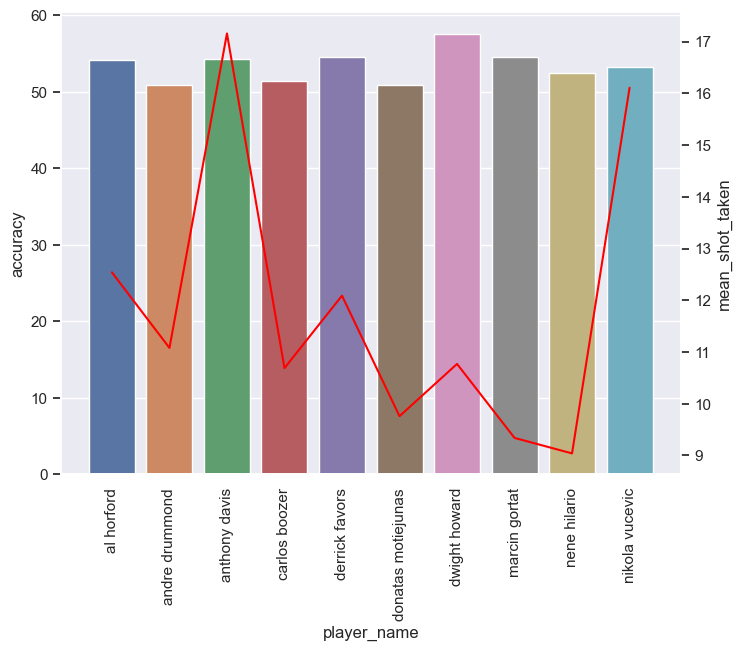

In [28]:
sns.set(rc={'figure.figsize':(8,6)})

fig = plt.figure()
ax1 = fig.add_subplot(111)
g = sns.barplot(x=top_accuracy.player_name, y=top_accuracy.accuracy ,ax=ax1)
g.set_xticklabels(labels = top_accuracy.player_name,  rotation=90)
ax2 = ax1.twinx()
h = sns.lineplot(x="player_name", y="mean_shot_taken", data=top_accuracy, ax=ax2, color="red")
h.set_xticklabels(labels = top_accuracy.player_name,  rotation=90)
ax2.grid(False)
plt.show()

In [29]:
shot_3 = data[data.SHOT_DIST >=24]

In [30]:
# 3 point Shot taken per game
shot3_taken = shot_3.groupby(['player_name', 'GAME_ID'])['SHOT_RESULT'].count()
shot3_taken = shot3_taken.reset_index()
shot3_taken = round(shot3_taken.groupby('player_name')['SHOT_RESULT'].mean(),2)
shot3_taken.head()

player_name
aaron brooks       3.07
aaron gordon       1.00
al farouq aminu    1.53
al horford         1.10
al jefferson       1.00
Name: SHOT_RESULT, dtype: float64

In [31]:
shot3_taken.mean()

2.2520717131474104

In [32]:
shot3_taken = shot3_taken.reset_index()
shot3_taken.columns = ['player_name', 'mean_shot']
shot3_taken.head()

,player_name,mean_shot
0,aaron brooks,3.07
1,aaron gordon,1.00
2,al farouq aminu,1.53
3,al horford,1.10
4,al jefferson,1.00


In [33]:
# Player has to take at least 9 shots per game 
players3_made = shot_3[shot_3.SHOT_RESULT == 'made'].groupby('player_name')['SHOT_RESULT'].count()
total_shots3_player = shot_3.groupby('player_name')['SHOT_RESULT'].count()
accuracy3_players = round(players3_made / total_shots3_player,4) *100

In [34]:
accuracy3_players

player_name
aaron brooks        40.70
aaron gordon        25.00
al farouq aminu     24.49
al horford           9.09
al jefferson       100.00
                    ...  
wesley johnson      33.04
wesley matthews     38.34
wilson chandler     33.20
zach lavine         29.41
zach randolph       66.67
Name: SHOT_RESULT, Length: 251, dtype: float64

In [35]:
accuracy3_players = accuracy3_players.reset_index()
accuracy3_players.columns = ['player_name', 'accuracy']
accuracy3_players['mean_shot_taken']  = shot3_taken['mean_shot']

In [36]:
accuracy3_players

,player_name,accuracy,mean_shot_taken
0,aaron brooks,40.70,3.07
1,aaron gordon,25.00,1.00
2,al farouq aminu,24.49,1.53
3,al horford,9.09,1.10
4,al jefferson,100.00,1.00
...,...,...,...
246,wesley johnson,33.04,2.40
247,wesley matthews,38.34,5.40
248,wilson chandler,33.20,4.23
249,zach lavine,29.41,1.79


In [37]:
top_accuracy3 = accuracy3_players[accuracy3_players.mean_shot_taken > 3]
top_accuracy3 = top_accuracy3.sort_values(['accuracy'], ascending=False)

In [38]:
top_accuracy3

,player_name,accuracy,mean_shot_taken
144,kyle korver,46.38,3.57
141,klay thompson,42.86,5.16
31,brandon knight,41.43,4.40
0,aaron brooks,40.70,3.07
197,paul pierce,40.57,3.24
38,channing frye,39.69,4.44
45,chris paul,39.34,3.46
55,danny green,39.34,3.64
224,stephen curry,39.22,6.64
247,wesley matthews,38.34,5.40


In [39]:
top_accuracy3 = top_accuracy3[:15]
top_accuracy3 = top_accuracy3.sort_values(['player_name'])
top_accuracy3 = top_accuracy3.reset_index(drop=True)

In [40]:
top_accuracy3

,player_name,accuracy,mean_shot_taken
0,aaron brooks,40.70,3.07
1,brandon knight,41.43,4.40
2,channing frye,39.69,4.44
3,chris bosh,37.30,3.07
4,chris paul,39.34,3.46
5,danny green,39.34,3.64
6,james harden,38.04,5.88
7,joe johnson,37.87,3.13
8,klay thompson,42.86,5.16
9,kyle korver,46.38,3.57


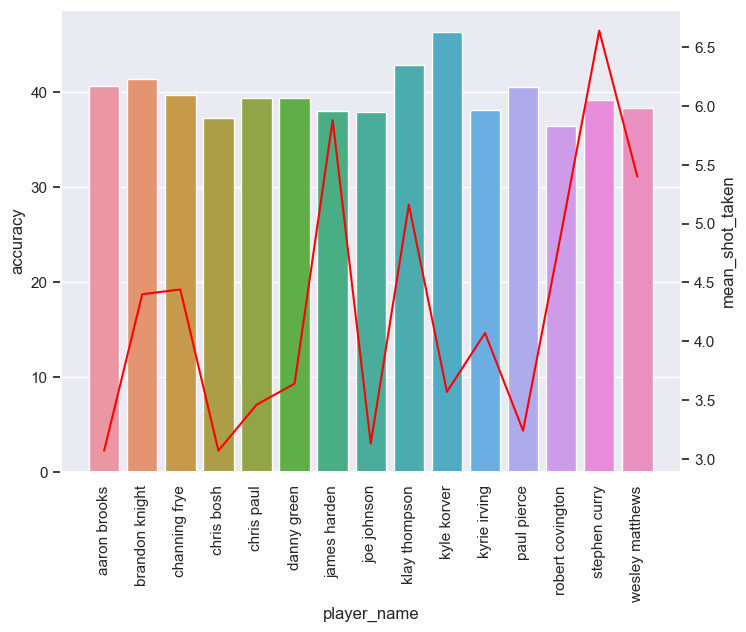

In [41]:
sns.set(rc={'figure.figsize':(8,6)})

fig = plt.figure()
ax1 = fig.add_subplot(111)
g = sns.barplot(x=top_accuracy3.player_name, y=top_accuracy3.accuracy ,ax=ax1)
g.set_xticklabels(labels = top_accuracy3.player_name,  rotation=90)
ax2 = ax1.twinx()
h = sns.lineplot(x="player_name", y="mean_shot_taken", data=top_accuracy3, ax=ax2, color="red")
h.set_xticklabels(labels = top_accuracy3.player_name,  rotation=90)
ax2.grid(False)
plt.show()

In [42]:
# The more shots you take, the more your accuracy should decrease
shot_accuracy3 = accuracy3_players[['accuracy', 'mean_shot_taken']]

In [43]:
shot_accuracy3 = shot_accuracy3.dropna()


In [44]:
shot_accuracy3 = shot_accuracy3.groupby('mean_shot_taken').mean()


In [45]:
shot_accuracy3 = shot_accuracy3.reset_index()


<Axes: xlabel='mean_shot_taken', ylabel='accuracy'>

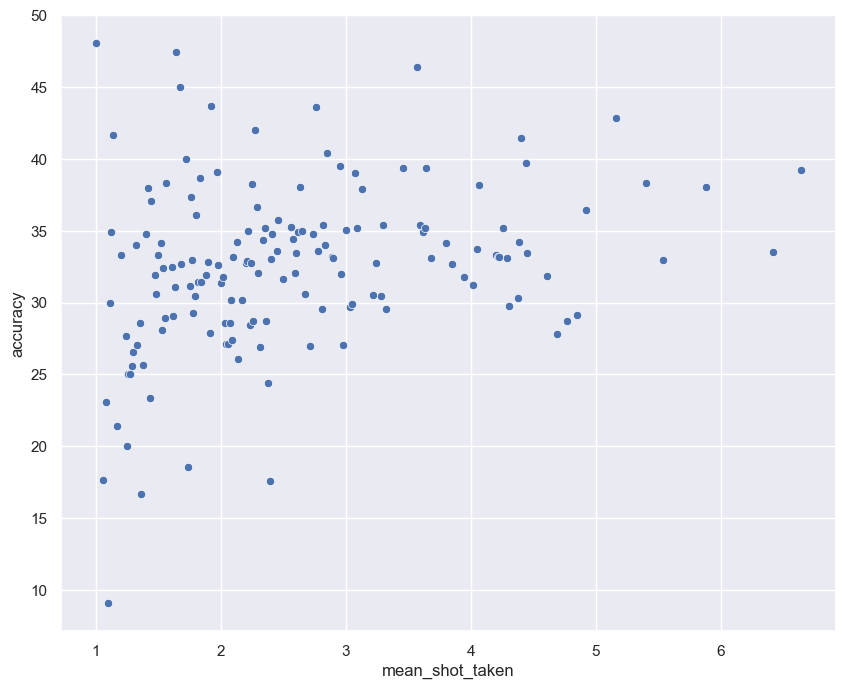

In [46]:
sns.set(rc={'figure.figsize':(10,8)})
sns.scatterplot(x='mean_shot_taken', y= 'accuracy', data=shot_accuracy3)

In [47]:
# Shot taken agianst player per game
shot_defend = data.groupby(['CLOSEST_DEFENDER', 'GAME_ID'])['SHOT_RESULT'].count()
shot_defend.head()

CLOSEST_DEFENDER  GAME_ID 
Acy, Quincy       21400010    6
                  21400018    5
                  21400041    5
                  21400061    2
                  21400075    6
Name: SHOT_RESULT, dtype: int64

In [48]:
shot_defend = shot_defend.reset_index()
shot_defend = round(shot_defend.groupby('CLOSEST_DEFENDER')['SHOT_RESULT'].mean(),2)
shot_defend = shot_defend.reset_index()
shot_defend.columns = ['CLOSEST_DEFENDER', 'mean_shot']
shot_defend.head()

,CLOSEST_DEFENDER,mean_shot
0,"Acy, Quincy",5.87
1,"Adams, Jordan",2.50
2,"Adams, Steven",9.68
3,"Adrien, Jeff",4.56
4,"Afflalo, Arron",7.90


In [49]:
shot_defend.mean_shot.mean()


6.192790697674417

In [50]:
shot_defend.mean_shot.max()


13.34

In [51]:
defender_miss = data[data.SHOT_RESULT == 'missed'].groupby('CLOSEST_DEFENDER')['SHOT_RESULT'].count()
total_shots_defender = data.groupby('CLOSEST_DEFENDER')['SHOT_RESULT'].count()
accuracy_defenders = round(defender_miss / total_shots_defender,4) *100

In [52]:
accuracy_defenders = accuracy_defenders.reset_index()
accuracy_defenders.columns = ['CLOSEST_DEFENDER', 'accuracy']
accuracy_defenders['mean_shot_defend']  = shot_defend['mean_shot']

In [53]:
accuracy_defenders

,CLOSEST_DEFENDER,accuracy,mean_shot_defend
0,"Acy, Quincy",57.25,5.87
1,"Adams, Jordan",46.67,2.50
2,"Adams, Steven",55.58,9.68
3,"Adrien, Jeff",45.21,4.56
4,"Afflalo, Arron",58.30,7.90
...,...,...,...
468,"Young, James",51.79,2.55
469,"Young, Nick",61.54,5.07
470,"Young, Thaddeus",51.88,9.85
471,"Zeller, Cody",56.65,8.95


In [54]:
top_def = accuracy_defenders[accuracy_defenders.mean_shot_defend > 10]
top_def = top_def.sort_values(['accuracy'], ascending=False)

In [55]:
top_def = top_def[:15]
top_def = top_def.sort_values(['CLOSEST_DEFENDER'])

In [56]:
top_def

,CLOSEST_DEFENDER,accuracy,mean_shot_defend
36,"Batum, Nicolas",58.73,10.02
49,"Bledsoe, Eric",56.92,10.66
90,"Collison, Darren",56.30,10.58
106,"Davis, Anthony",59.44,12.43
142,"Favors, Derrick",57.02,10.68
155,"Gasol, Marc",56.44,10.48
168,"Gortat, Marcin",56.10,11.28
172,"Green, Draymond",59.92,12.95
185,"Harden, James",56.51,10.29
205,"Holiday, Jrue",56.85,10.65


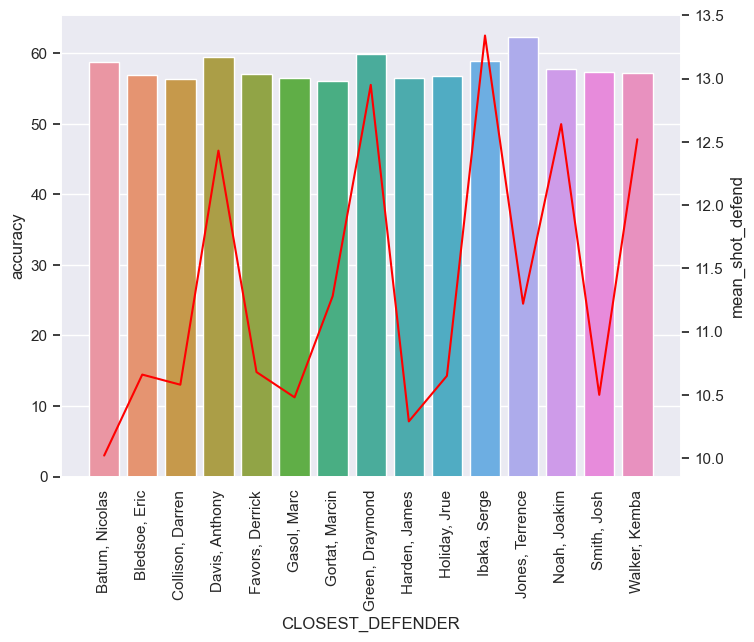

In [57]:
sns.set(rc={'figure.figsize':(8,6)})

fig = plt.figure()
ax1 = fig.add_subplot(111)
g = sns.barplot(x=top_def.CLOSEST_DEFENDER, y=top_def.accuracy ,ax=ax1)
g.set_xticklabels(labels = top_def.CLOSEST_DEFENDER,  rotation=90)
ax2 = ax1.twinx()
h = sns.lineplot(x="CLOSEST_DEFENDER", y="mean_shot_defend", data=top_def, ax=ax2, color="red")
h.set_xticklabels(labels = top_def.CLOSEST_DEFENDER,  rotation=90)
ax2.grid(False)
plt.show()